# **LP3 TIME SERIES REGRESSION ANALYSIS**

## **1. Business Understanding**

#### **Introduction**

**`Corporación Favorita C.A.`** is an Ecuadorian conglomerate of self-service stores, real estate investments, electricity generation, production of food and basic necessities, commerce, and hardware. The company is currently present in 6 countries: Costa Rica, Chile, Ecuador, Panama, Paraguay and Peru; its shares are listed on the Quito Stock Exchange and the Guayaquil Stock Exchange. They have large distribution chains and therefore since they deal with transport and logistics across large areas, It would be optimal if they knew which products needed to be where at what time allowing them to implementing Supply Chain Techniques for ensuring business performance like Just-In-Time or LIFO.

**Business Objective:**

Management wants to ensure they always have the right quantity of products in stock in their stores in Equador.

**Data Dictionary**

The marketing team has given us the following data that relates to the Equadorian Market.

1. They have a lot of products and they have been grouped into 'families' constituting the type of product sold.
2. The "train" dataset is the primary area of focus and includes dates, store, and familie, whether that family was being promoted, as well as the sales numbers.
3. Additional datasets include supplementary information that may be useful in building your models.

**File Descriptions and Data Field Information**

**train.csv**
carries all details regarding product, store, sales and promotion

| Field | Description |
|----------|-----------|
| 1. date | The date at which the transaction happened for each product family and each store from 2013-01-01 to 2017-08-15 | 
| 2. store_nbr | identifies the store at which the products are sold. |
| 3. family | identifies the type of product sold. |
| 4. sales | gives the total sales for a product family at a particular store at a given date. |
| 5. onpromotion | gives the total number of items in a product family that were being promoted on the given given date. |

**transaction.csv**
Shows the count of transactions of each store

| Field | Description |
|----------|-----------|
| 1. date | date of transactions from 2013-01-01 to 2017-08-15 | 
| 2. store_nbr | store where transactions happened |
| 3. transactions | sum of transactions made on that specific date for all product families. |

**stores.csv**
Shows the Metadata of stores.

| Field | Description |
|----------|-----------|
| city | city where store is located |
| state | state where store is located |
| type | proprietary order ranking of stores |
| cluster | a grouping of similar stores |

**oil.csv**
shows the price of oil in Equador

| Field | Description |
|----------|-----------|
| date | date of oil price record from 2013-01-01 to 2017 - 2017-08-31 |
| dcoilwtico | Daily oil price | 

`Note:`
(Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)

**holidays_events.csv**
Shows holidays and events occuring in Equador 

| Field | Description |
|----------|-----------|
| date | date of occurence from 2012-03-02 to 2017-12-26 |
| type | Shows whether it was 'Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event' | 
| locale | shows Whether the holiday was 'Local', 'Regional' or 'National' |
| locale_name | name of locale 
| description | Holiday Name |
| transferred | shows whether the holiday was transferred or not | 


`NOTE:`

1. Pay special attention to the 'type' column. Category descriptions are as follows 

1. A holiday that is type `transferred` officially falls on that calendar day but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. 

2. Days that are type `Bridge` are extra days that are added to a holiday (e.g., to extend the break across a long weekend). 

3. The type `Work Day` which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

4. `Additional` holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

**Additional Notes**

1. Wages in the public sector are paid every two weeks on the `15th` and on the `last day of the month`. Supermarket sales could be affected by this.

2. A magnitude 7.8 earthquake struck Ecuador on `April 16, 2016`. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

**`HYPOTHESIS`**

`H0: Oil price has no impact on the sales of the products in the stores.`

`H1: Oil price has an impact on the sales of the products in the stores.`

**`Analytical Questions:`** 

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.


## **Extract Data**

In [2]:
import os
import pyodbc
from dotenv import load_dotenv, dotenv_values, find_dotenv
import pandas as pd

print('all libraries loaded successfully')

all libraries loaded successfully


In [3]:
#reading data from database
#Load environment variables from .env file into a dictionary variable
#.env file MUST be in the same root as the notebook to work or alternatively use find_dotenv
environment_variables=dotenv_values(find_dotenv('.env'))
# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

#Connecting to the database
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

# Using the connect method of the pyodbc library.
# This will connect to the server. 
# connection=pyodbc.connect(connection_string)

#hide warnings
import warnings

warnings.filterwarnings('ignore')

print("connected successfully")

connected successfully


In [4]:
#reading data from the remote database table
query='''SELECT * 
        FROM dbo.oil'''
        
#oil=pd.read_sql(query,connection)

#oil.to_csv('../Datasets/oil.csv', index=False)

In [5]:
#reading data from the remote database table
query='''SELECT * 
        FROM dbo.holidays_events'''
        
#holidays=pd.read_sql(query,connection)

#holidays.to_csv('../Datasets/holidays.csv', index=False)

In [6]:
#reading data from the remote database table
query='''SELECT * 
        FROM dbo.stores'''
        
#stores=pd.read_sql(query,connection)

#stores.to_csv('../Datasets/stores.csv', index=False)

## **2. Data Understanding**

#### **`Importation`**

In [7]:
#import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from itertools import *
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
import pmdarima as pm
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb

#pandas options
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [8]:
#import data
train = pd.read_csv('../Datasets/train.csv') 
transactions = pd.read_csv('../Datasets/transactions.csv')
oil = pd.read_csv('../Datasets/oil.csv')
stores = pd.read_csv('../Datasets/stores.csv')
holidays = pd.read_csv('../Datasets/holidays.csv')

#### **`Exploratory Data Analysis`**

In [9]:
#let's dive into the train
train.sample(4)

id        date  store_nbr       family    sales  onpromotion
1837413  1837413  2015-10-31         14  CELEBRATION    16.00            0
1306674  1306674  2015-01-06         22  CELEBRATION     0.00            0
826558    826558  2014-04-10         50     CLEANING 1,071.00            0
879656    879656  2014-05-10         40        DAIRY   564.00            0

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


* make date datetime and index for time series modelling.
* drop id column.
* store_nbr is a category and family is also a category

In [11]:
train['date'] = pd.to_datetime(train.date) #convert date to datetime
train['store_nbr'] = train.store_nbr.astype('category') #convert store_nbr to category
train['family'] = train.family.astype('category') #convert family to category
train = train.drop(columns='id').set_index('date') #drop id and set date as index
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 4 columns):
 #   Column       Dtype   
---  ------       -----   
 0   store_nbr    category
 1   family       category
 2   sales        float64 
 3   onpromotion  int64   
dtypes: category(2), float64(1), int64(1)
memory usage: 74.4 MB


In [12]:
train.sample(3)

store_nbr                      family    sales  onpromotion
date                                                                  
2013-03-24         6                    CLEANING 1,408.00            0
2016-01-04        22                   HOME CARE   194.00            0
2017-01-17        44  SCHOOL AND OFFICE SUPPLIES    16.00            0

In [13]:
train.describe(include='all').T

count unique         top      freq   mean      std  min  \
store_nbr   3,000,888.00  54.00        1.00 55,572.00    NaN      NaN  NaN   
family           3000888     33  AUTOMOTIVE     90936    NaN      NaN  NaN   
sales       3,000,888.00    NaN         NaN       NaN 357.78 1,102.00 0.00   
onpromotion 3,000,888.00    NaN         NaN       NaN   2.60    12.22 0.00   

             25%   50%    75%        max  
store_nbr    NaN   NaN    NaN        NaN  
family       NaN   NaN    NaN        NaN  
sales       0.00 11.00 195.85 124,717.00  
onpromotion 0.00  0.00   0.00     741.00

1. The `mean` @ `357.78` and `median` @ `11.0` of the sales are very far apart indicating that the data could be highly skewed and imbalanced.
2. The maximum number of items promoted in a day was 741

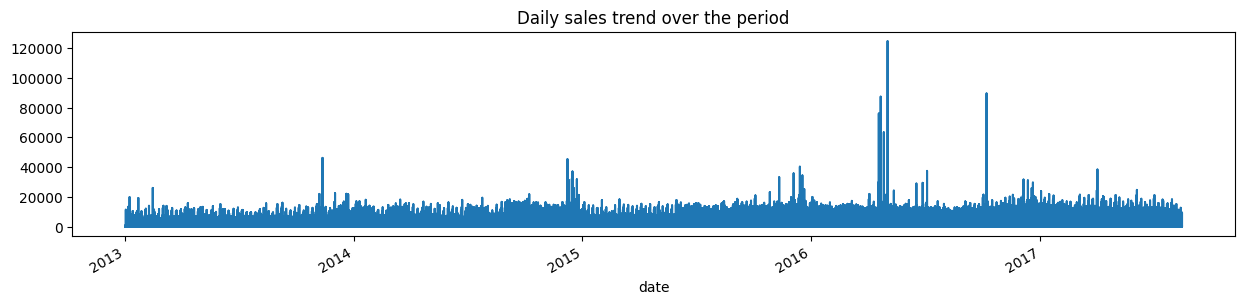

In [14]:
#checking trend and seasonality
train.sales.plot(figsize=(15,3))
plt.title('Daily sales trend over the period')
plt.show()

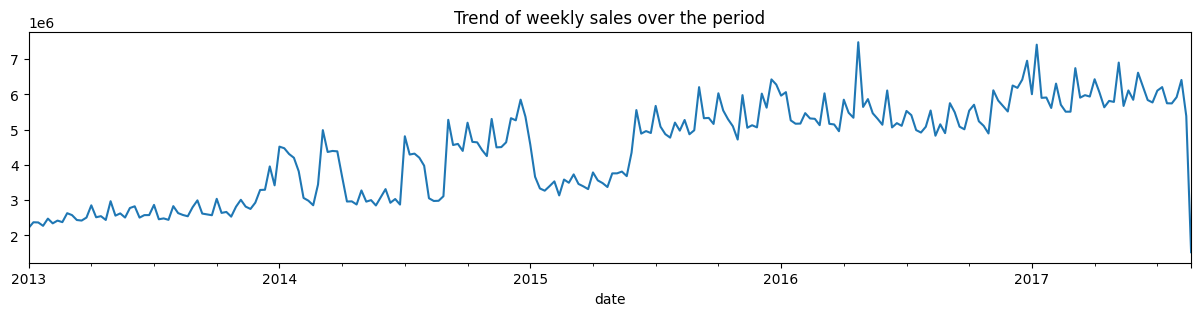

In [15]:
#checking seasonality and trend by weekly sales
train.sales.resample('W').sum().plot(figsize=(15,3))
plt.title('Trend of weekly sales over the period')
plt.show()

* There is an upward trend.
* There could be weekly seasonality although it's not very clear

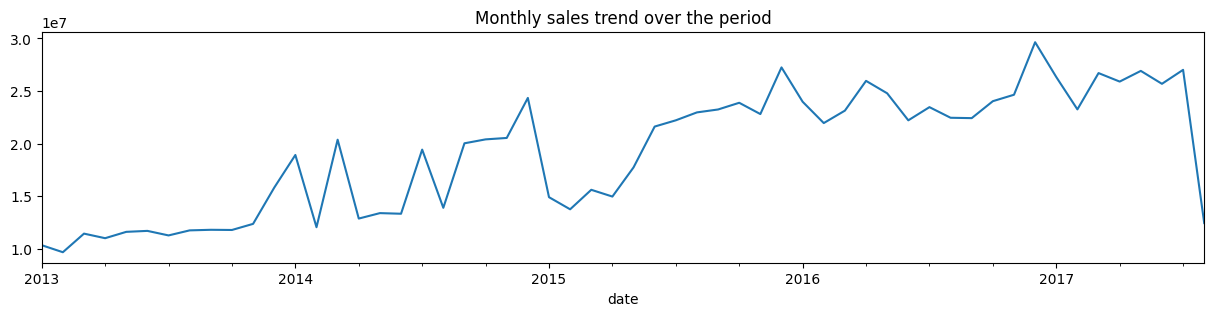

In [16]:
# check trend and seasonality by month
train.sales.resample('ME').sum().plot(figsize=(15,3))
plt.title('Monthly sales trend over the period')
plt.show()

* Upward trend persists but the seasonality disappears in monthly

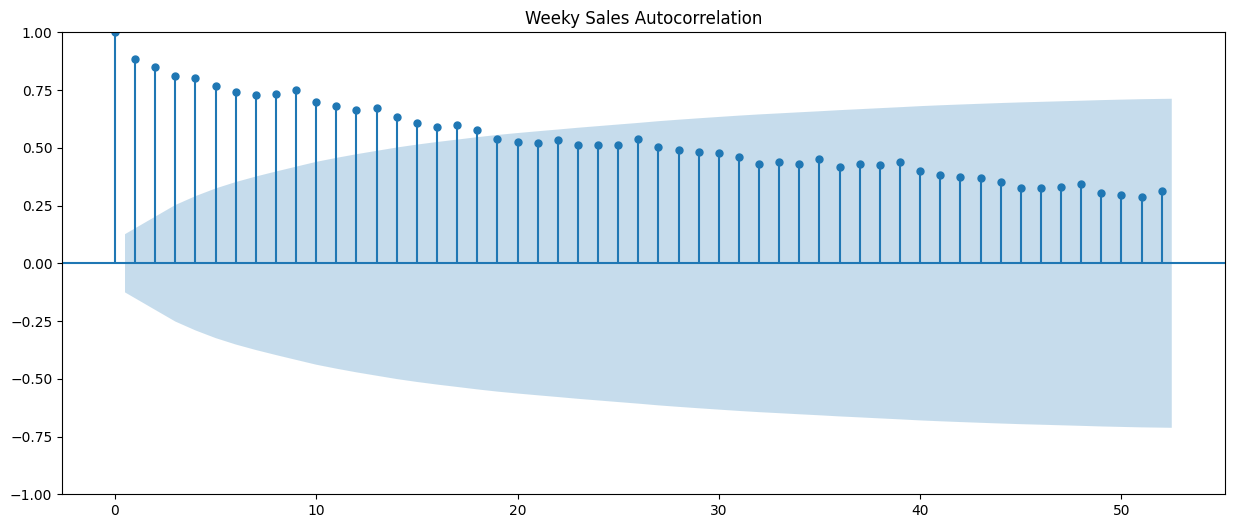

In [17]:
#plotting weekly sales autocorrelation
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(train.sales.resample('W').sum(), lags=52, title='Weeky Sales Autocorrelation', ax=ax)
plt.show()

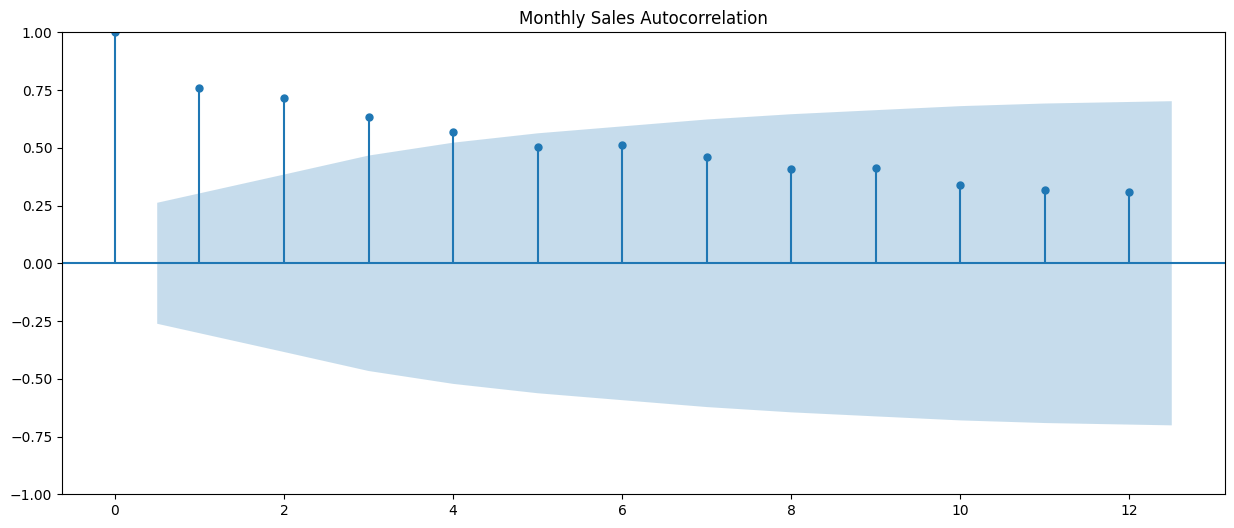

In [18]:
#plotting monthly autocorrelation
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(train.sales.resample('ME').sum(), lags=12, title='Monthly Sales Autocorrelation', ax=ax)
plt.show()

* There is high inital autocorrelation which wanes over time both weekly and monthly aggregations.
* This implies our data is highly impacted by it's recent past for both monthly and weekly time periods. i.e last week sales impact this week sales, but the longer the period, then the lower the impact on sales.
* Check lagplots as well

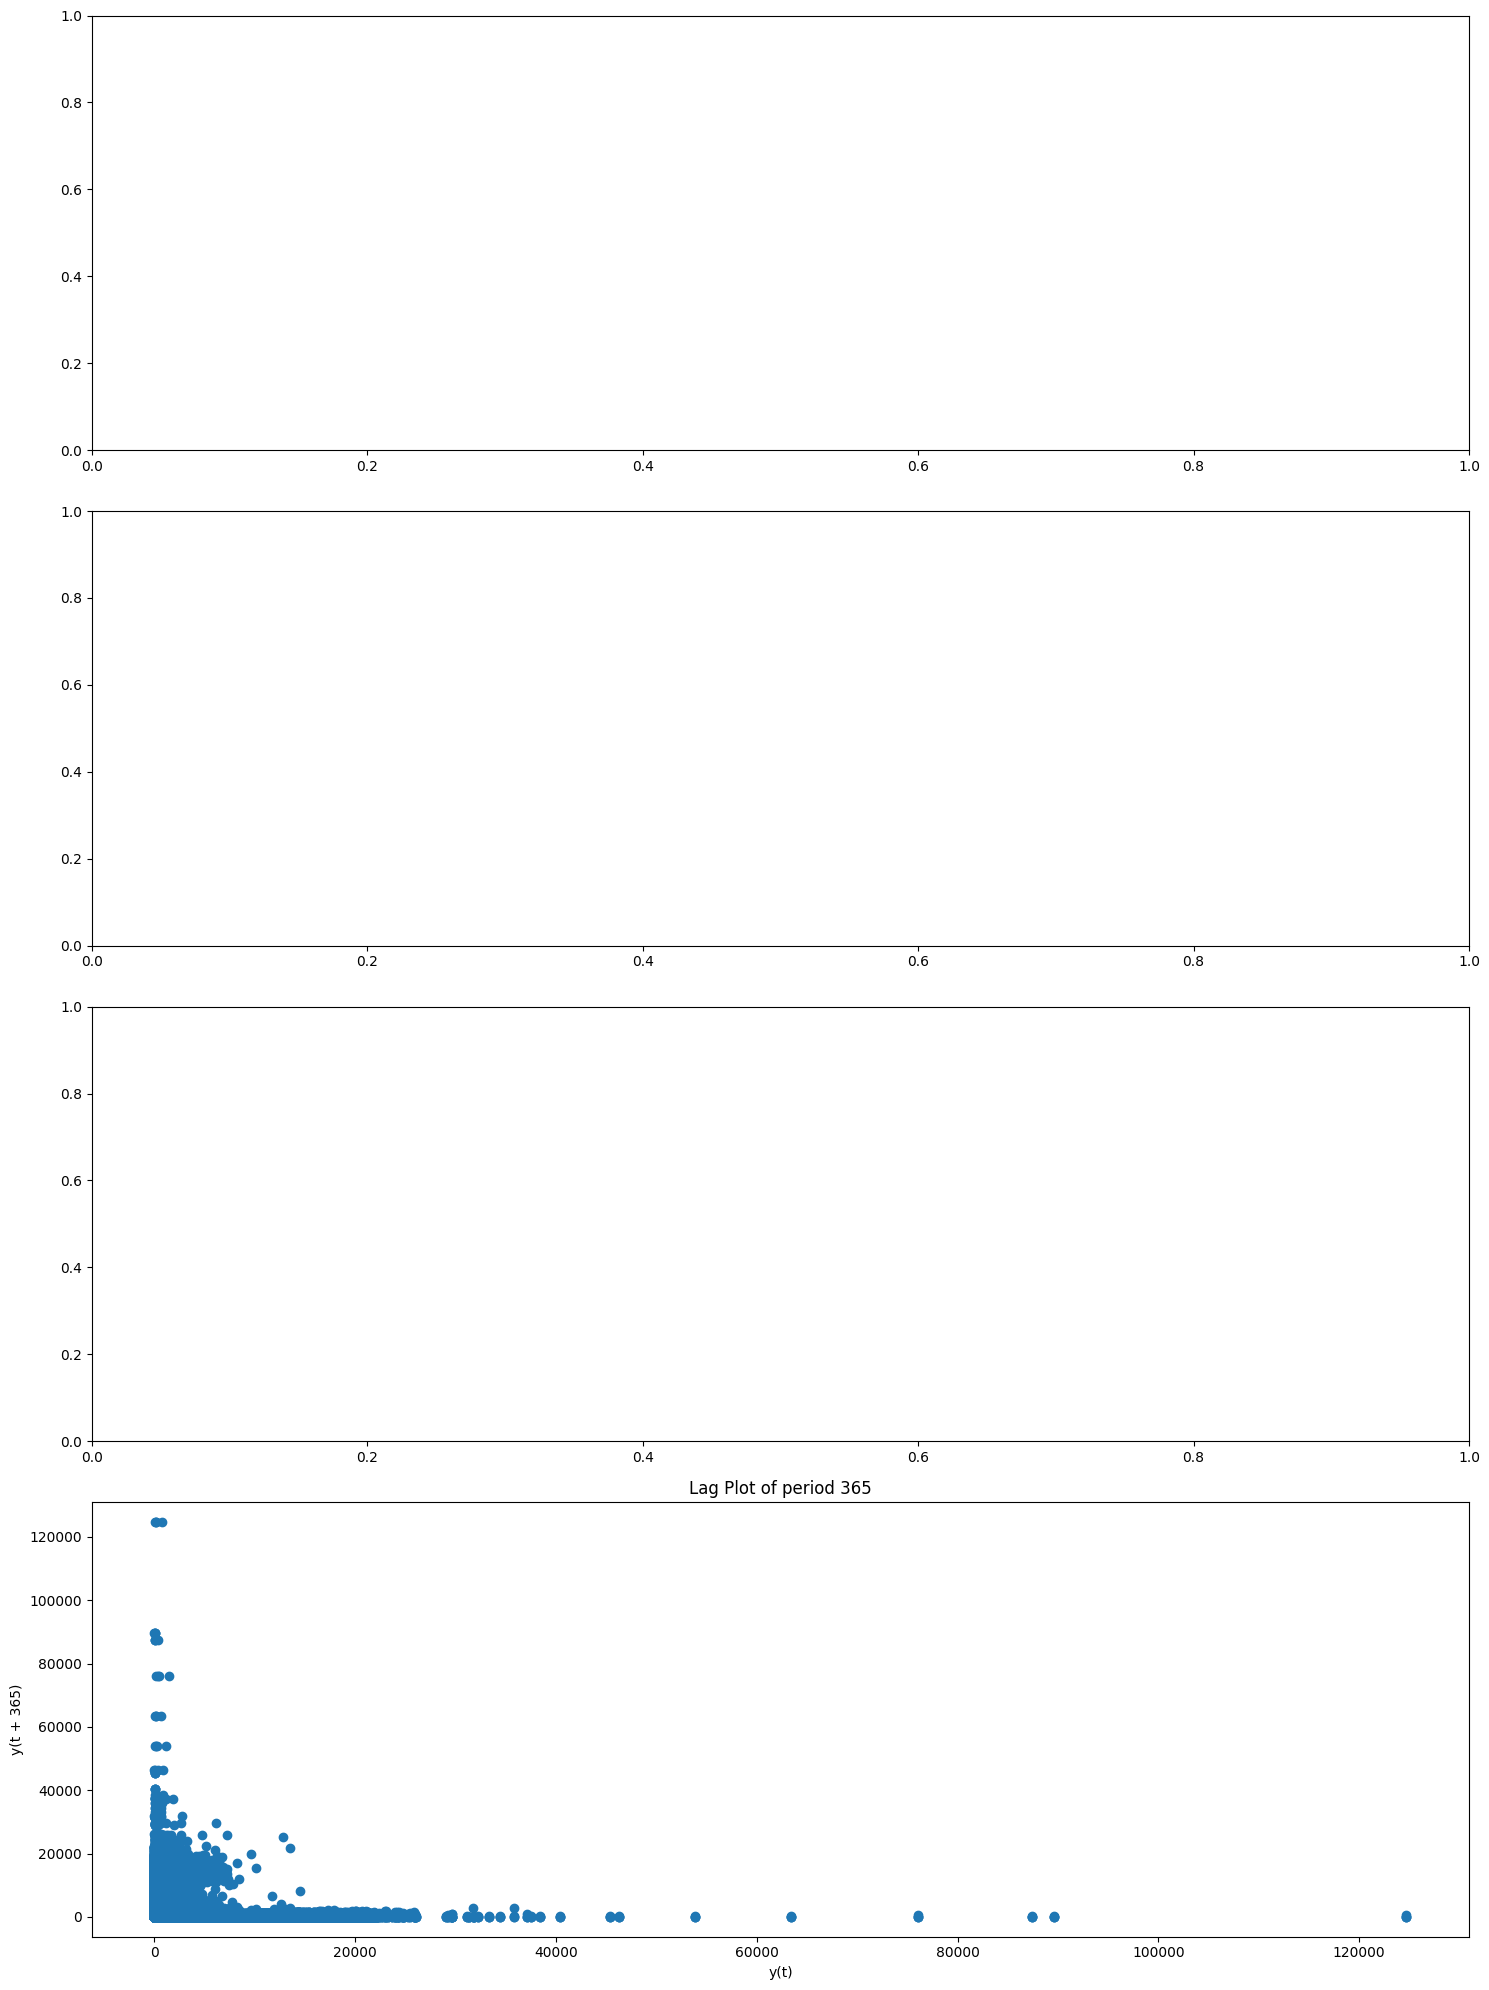

In [67]:
#plotting lag plot of the data using period 1, 7, 30, 365 days
lags = [1, 7, 30, 365]

fig, axs = plt.subplots(4,1, figsize=(15,20))

for i, period in enumerate(lags):
    axs[i] = pd.plotting.lag_plot(train['sales'], lag=period)
    axs[i].set_title(f'Lag Plot of period {period}')
    plt.tight_layout()

plt.show()

**Lag Plot of Period 1 Day, 7 days, 30 days and 365 days:**
* All lagplots form the same basic pattern, of concentration of points towards the origin and similar dipersed points further on both axes.
* The concentration of points at the lower end of both axes suggests a pattern: when sales are low on a particular day, they tend to remain low one period later.
* The isolated dots at higher values indicate occasional exceptions where high sales on a specific day are positively correlated with high sales one period later.

**H 0:** There is no autocorrelation in sales.

**H 1:** There is autocorrelation in sales.

#### Check for autocorrelation using the Durbin-Watson test.

In [20]:
from statsmodels.stats.stattools import durbin_watson

dw_test = durbin_watson(train["sales"].diff().dropna())

print("Durbin-Watson Test Results:")
print("Test Statistic:", dw_test)

if dw_test < 1.5:
    print("Reject the null hypothesis. There is significant positive autocorrelation.")
elif dw_test > 2.5:
    print("Reject the null hypothesis. There is significant negative autocorrelation.")
else:
    print("Fail to reject the null hypothesis. There is no significant autocorrelation.")

Durbin-Watson Test Results:
Test Statistic: 3.0514646987696477
Reject the null hypothesis. There is significant negative autocorrelation.


To account for significant negative autocorrelation in time series data, it is often necessary to use more advanced forecasting methods, such as SARIMA / ARIMA models or state-space models, which can explicitly model the autocorrelation structure of the data.

A significant negative autocorrelation in time series data implies that the current observation is likely to be lower than the previous observation, and that the previous observation is likely to be higher than the observation before that. In other words, the data exhibits a "mean-reverting" behavior, where the values tend to fluctuate around a stable mean value, which can be looked at as a regression problem as well. Making it possible to use gradient boosting algorithms to model the forecasts.

#### Checking Data Completeness

`H0: The data is complete`

`H1: The data is incomplete`

In [25]:
#checking for data completeness
start_date = train.index.min()
end_date = train.index.max()
print(f'The data starts on {start_date} and ends on {end_date},\ncovering a period of {end_date - start_date} hours\n')

date_range = pd.date_range(start_date, end_date) #get range of dates between first and last day of record

missing_days = date_range.difference(train.index) #check missing days

if len(missing_days) == 0: #check hypothesis
    print(f'The Dataset is complete')
else: 
    print(f'The Dataset is incomplete \n\n' 
          f'Here are the the unique missing dates in the data \n{pd.Series(missing_days)}')

The data starts on 2013-01-01 00:00:00 and ends on 2017-08-15 00:00:00,
covering a period of 1687 days 00:00:00 hours

The Dataset is incomplete 

Here are the the unique missing dates in the data 
0   2013-12-25
1   2014-12-25
2   2015-12-25
3   2016-12-25
dtype: datetime64[ns]


* The missing days all fall on Christmass of each year. We will assume that these days the stores were closed and fill with 0

In [26]:
#Create a new dataframe to fill the missing days for all stores and product families
#extracting the unique store numbers and families
unique_stores = train['store_nbr'].unique()
families = train['family'].unique()
print(f'There are {unique_stores.size} unique stores and {families.size} unique family groups')

#Creating data for the missing days.
missing_data = product(missing_days, unique_stores, families) #use itertools product method to create data for each store and family on each date.

#convert to a dataframe and set date as index 
missing_df = pd.DataFrame(missing_data, columns=['date','store_nbr','family']).set_index('date')

#add the sales and onpromotion columns with 0
missing_df['sales'] = 0
missing_df['onpromotion'] = 0

#new dataset for all missing days
print(f'Train before = {train.shape}')
print(f'Missing_data = {missing_df.shape}')

# Concatenate missing_df with train
train = pd.concat([train, missing_df])
print(f'Train after = {train.shape}')

There are 54 unique stores and 33 unique family groups
Train before = (3000888, 4)
Missing_data = (7128, 4)
Train after = (3008016, 4)


* Adding the missing dates to the train data increases observations by 7128

#### Check Seasonality and Trend

The data has shown strong short term autocorrelation across Daily, Weekly, Monthly and Annual periods. Let's check for seasonality and trend for each period. 

In [64]:
# function to check Seasonality across different time periods.
def check_seasonality(df,col, model = 'additive'):
    '''
    Function to check seasonality, trend and residuals across daily, weekly, monthly and Annual time frames. 
    Requires installation of seasonal decompose from statsmodels.
    
    df = dataframe, index must be in datetime
    col = column to be checked
    
    '''
    time_period = ['D','W','ME','Y']
    
    fig,axs = plt.subplots(4,1, figsize=(15,20))
    
    for i, period in enumerate(time_period):
        df_period = df[col].resample(period).sum()
        if i == 0:
            result = seasonal_decompose(df_period, model=model, period=365)
        elif i == 1:
             result = seasonal_decompose(df_period, model=model, period=52)
        elif i == 2:
            result = seasonal_decompose(df_period, model=model, period=12)
        else:
            result = seasonal_decompose(df_period, model=model, period=1)
        
        axs[i].set_title(f'Decomposition of {col} for {period} period')
        result.trend.plot(ax=axs[i], label='Trend')
        result.seasonal.plot(ax=axs[i], label='Seasonal')
        result.resid.plot(ax=axs[i], label='Residual', linestyle = '--')
        axs[i].legend()
        fig.tight_layout()
    
    plt.show()
        
        

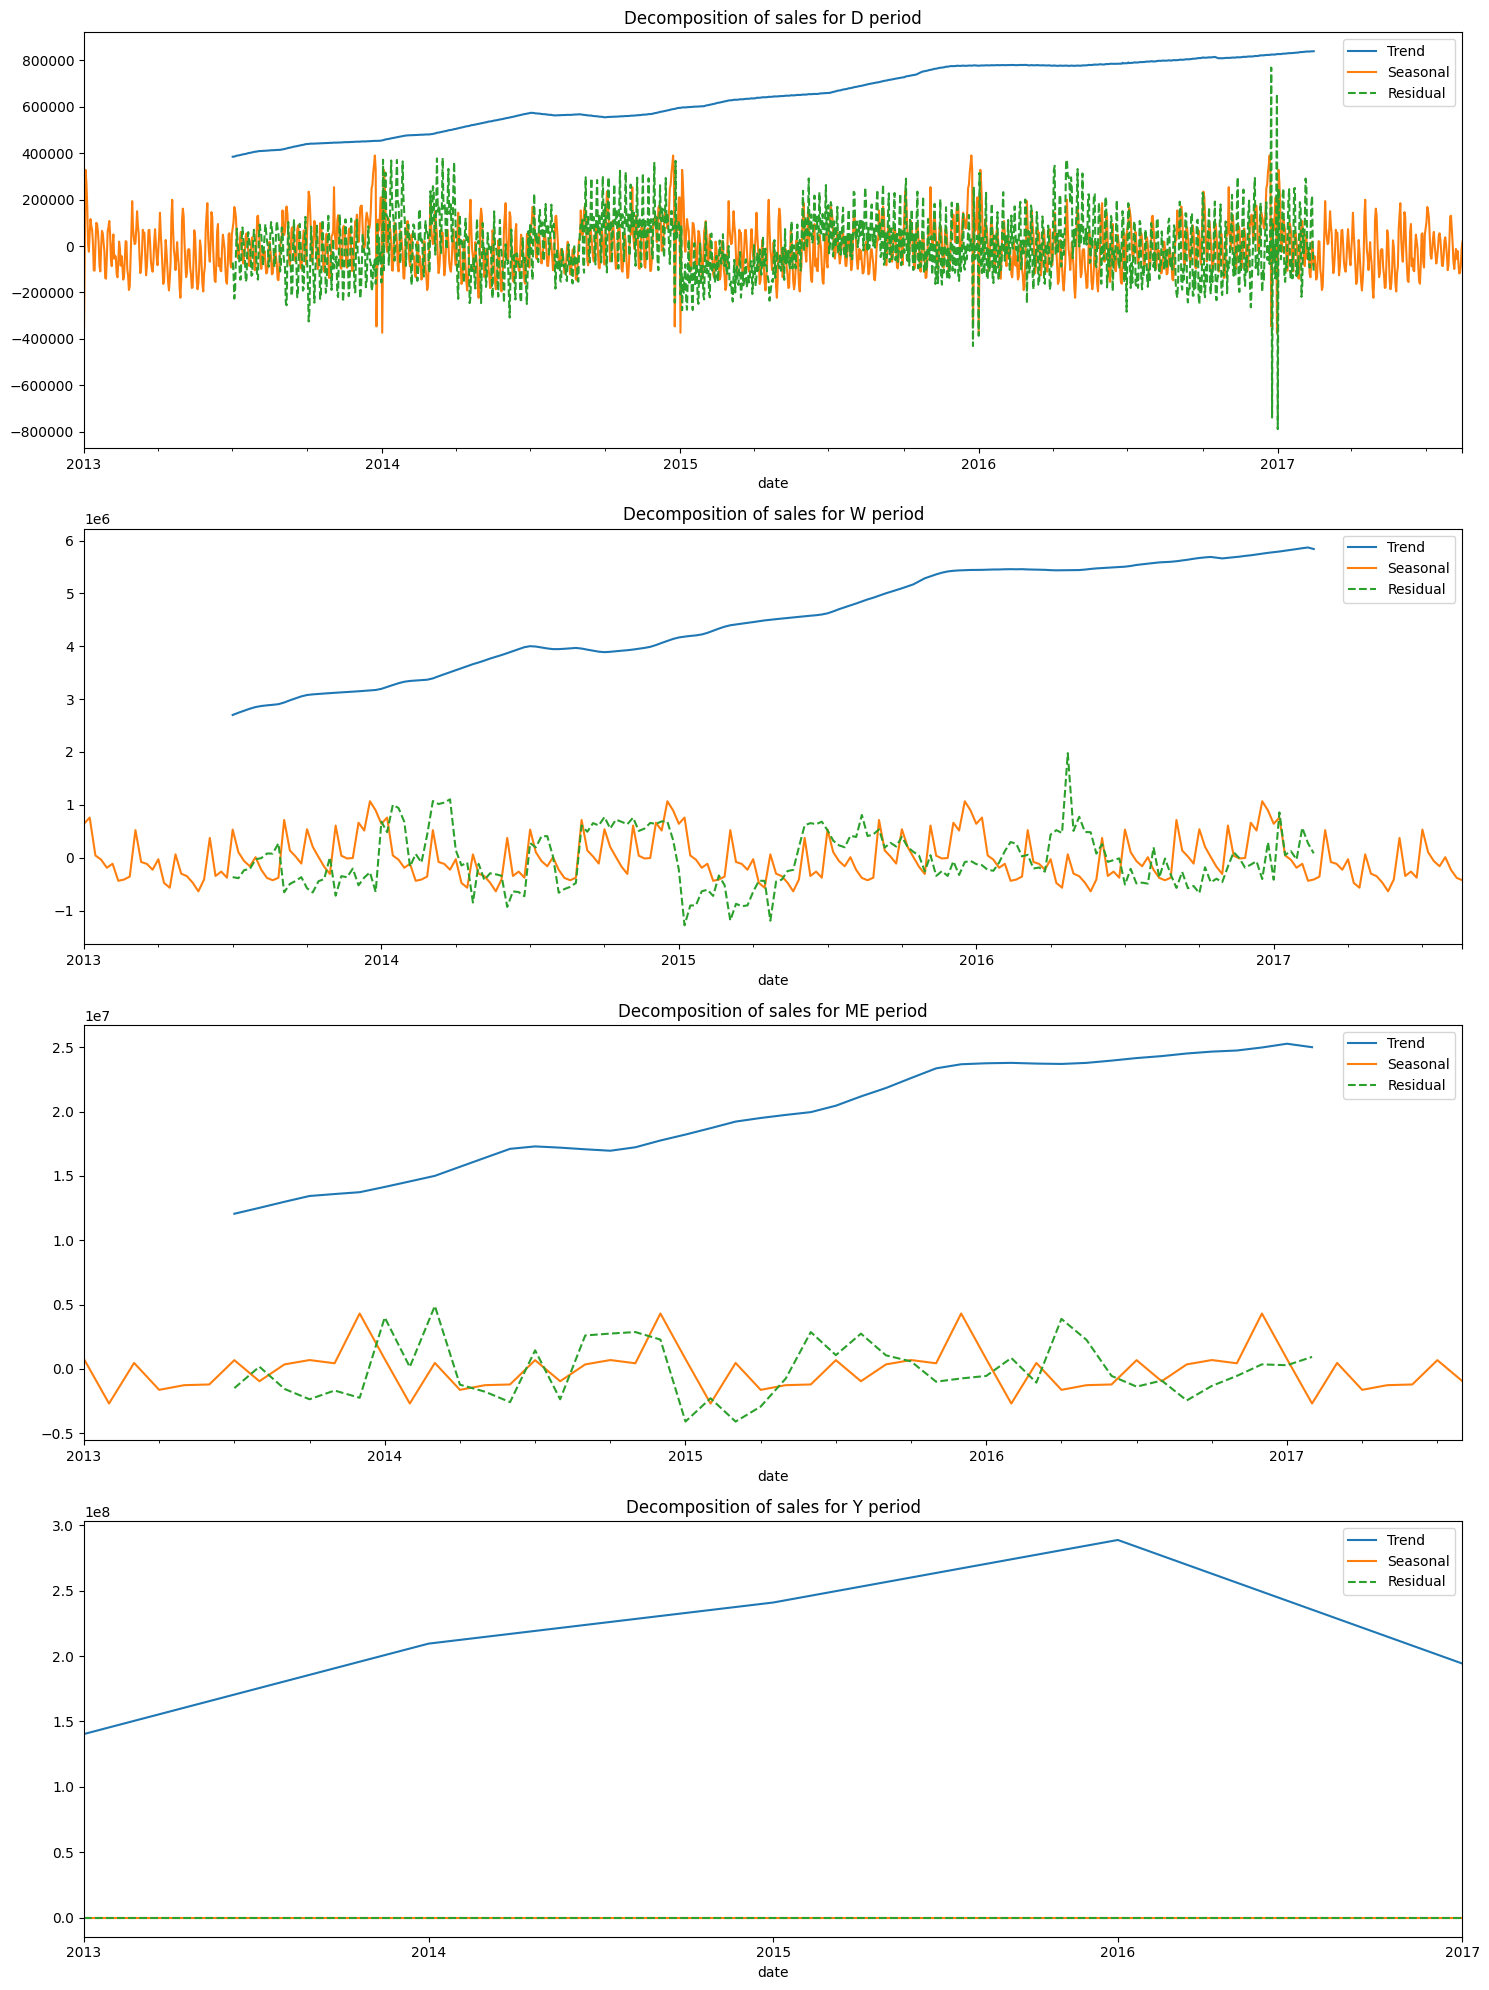

In [65]:
check_seasonality(train,col='sales')

* The daily data has no visible seasonality and no pattern in the residuals which would be contrary to the autocorrelation plot, However, when aggregated to weekly and monthly it shows a pattern that is concurrent with the autocorrelation.

* The daily shows little pattern, let's look into forecasting on the weekly timeframe.

In [70]:
#Checking stationarity in weekly sales with the Adfuller test
result = adfuller(train['sales'].resample('D').sum(), regression='c', autolag='AIC')
ADF_Statistic = result[0]
p_value = result[1]

print(f'ADF Statistic: {ADF_Statistic:.2f}\n',
      f'p_value: {p_value:.2f}\n')

if p_value > 0.05:
    print('The data is not stationary')
else:
    print('The data is stationary')

ADF Statistic: -2.57
 p_value: 0.10

The data is not stationary


In [25]:
#Checking stationarity in weekly sales with the Adfuller test
result = adfuller(train['sales'].resample('W').sum(), regression='c', autolag='AIC')
ADF_Statistic = result[0]
p_value = result[1]

print(f'ADF Statistic: {ADF_Statistic:.2f}\n',
      f'p_value: {p_value:.2f}\n')

if p_value > 0.05:
    print('The data is not stationary')
else:
    print('The data is stationary')

ADF Statistic: -1.91
 p_value: 0.33

The data is not stationary


In [26]:
#Checking stationarity in monthly sales with the Adfuller test
result = adfuller(train['sales'].resample('ME').sum(), regression='c')
ADF_Statistic = result[0]
p_value = result[1]

print(f'ADF Statistic: {ADF_Statistic:.2f}\n',
      f'p_value: {p_value:.2f}\n')

if p_value > 0.05:
    print('The data is not stationary')
else:
    print('The data is stationary')

ADF Statistic: -2.05
 p_value: 0.27

The data is not stationary


* The data is not stationary across both weekly and monthly timeframes

`Univariate Analysis`

In [27]:
train.dtypes

store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

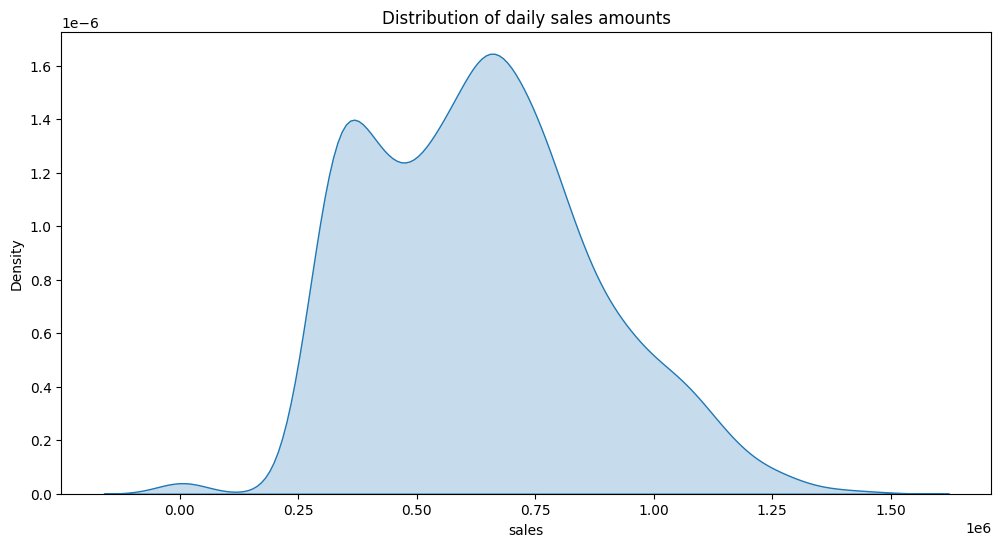

In [71]:
#check daily sales distribution
plt.figure(figsize=(12,6))
sns.kdeplot(data=train['sales'].resample('D').sum(), fill=True)
plt.title('Distribution of daily sales amounts')
plt.show()

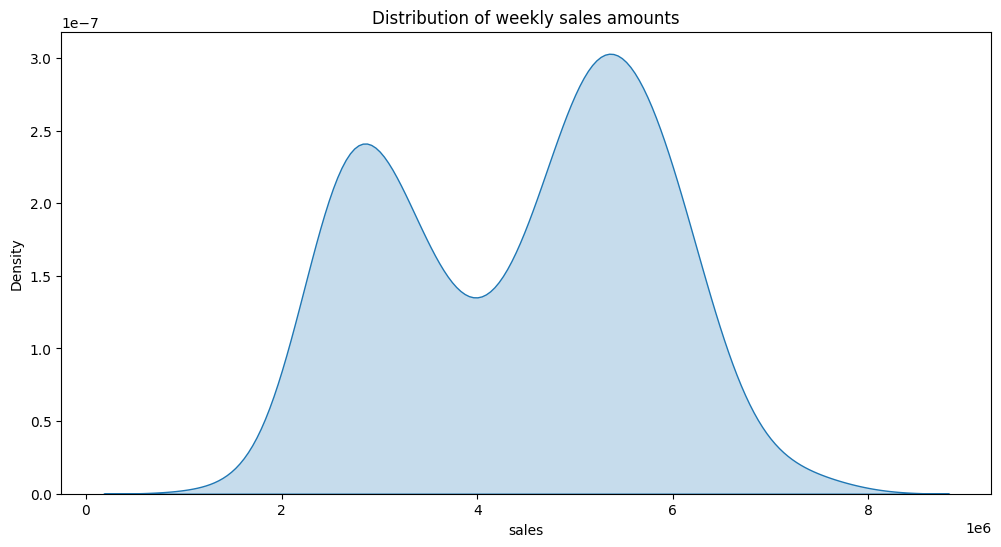

In [29]:
#check weekly sales distribution
plt.figure(figsize=(12,6))
sns.kdeplot(data=train['sales'].resample('W').sum(), fill=True)
plt.title('Distribution of weekly sales amounts')
plt.show()

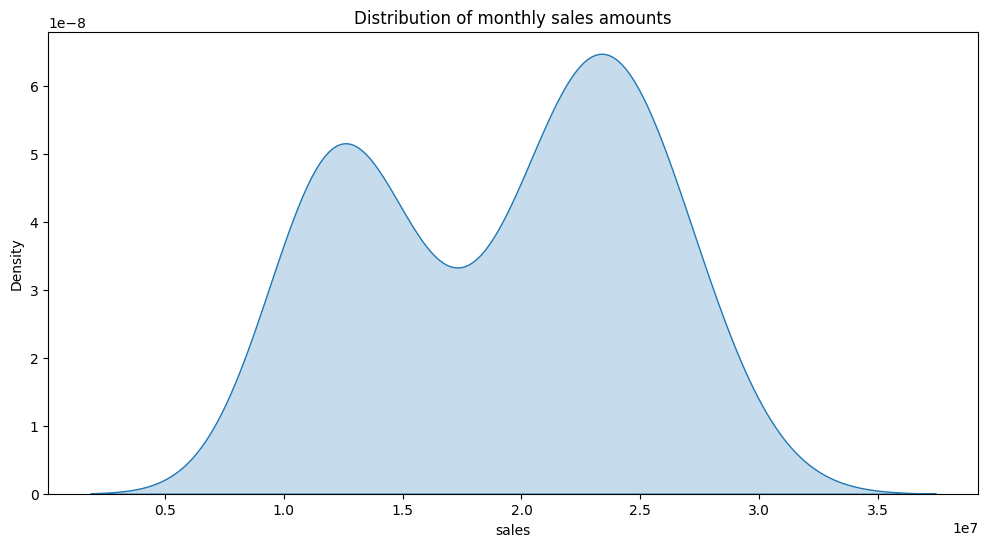

In [30]:
#check monthly sales distribution
plt.figure(figsize=(12,6))
sns.kdeplot(data=train['sales'].resample('ME').sum(), fill=True)
plt.title('Distribution of monthly sales amounts')
plt.show()

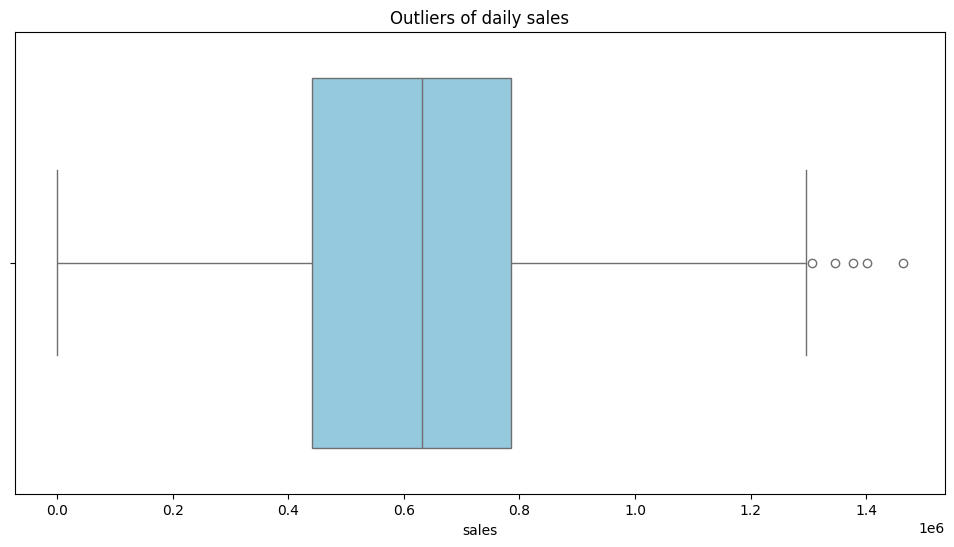

In [72]:
#checking for outliers in daily sales
plt.figure(figsize=(12,6))
sns.boxplot(data=train['sales'].resample('D').sum(), color='skyblue', orient='h')
plt.title('Outliers of daily sales')
plt.show()

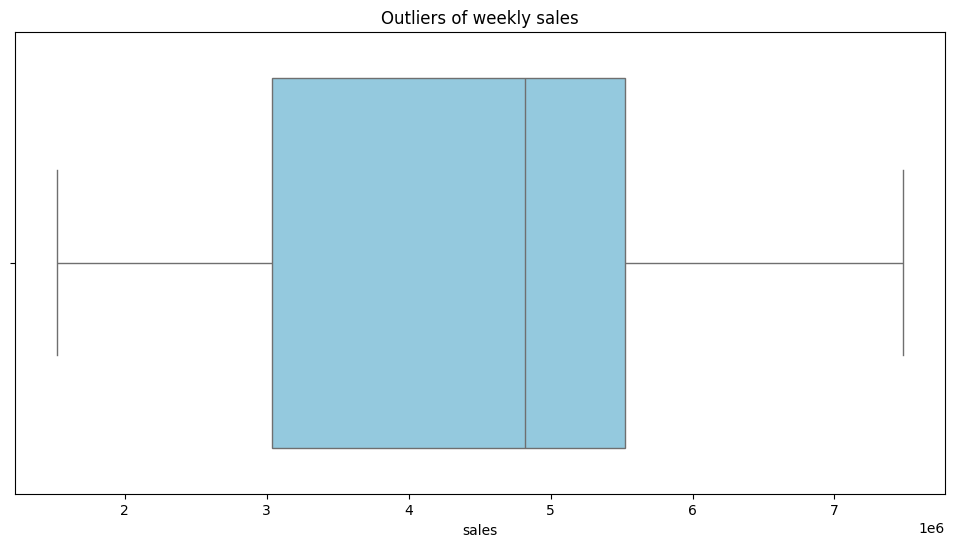

In [32]:
#checking for outliers in weekly sales
plt.figure(figsize=(12,6))
sns.boxplot(data=train['sales'].resample('W').sum(), color='skyblue', orient='h')
plt.title('Outliers of weekly sales')
plt.show()

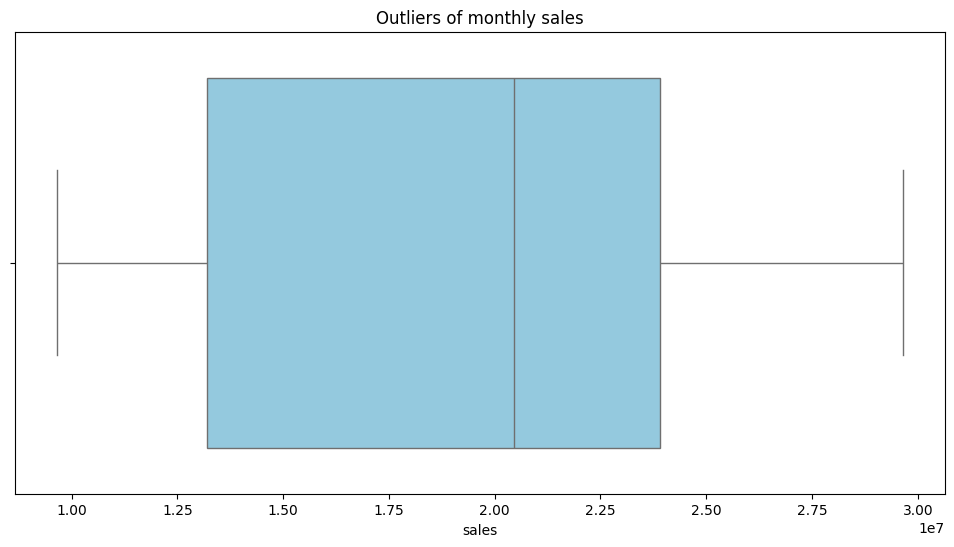

In [33]:
#checking for outliers in monthly sales
plt.figure(figsize=(12,6))
sns.boxplot(data=train['sales'].resample('ME').sum(), color='skyblue', orient='h')
plt.title('Outliers of monthly sales')
plt.show()

* The average daily sale is a low value close to nil and there are too many outliers. It will possibly impact performance negatively. 
* We will model and predict using the weekly and monthly timeframes

`Bivariate Analysis`

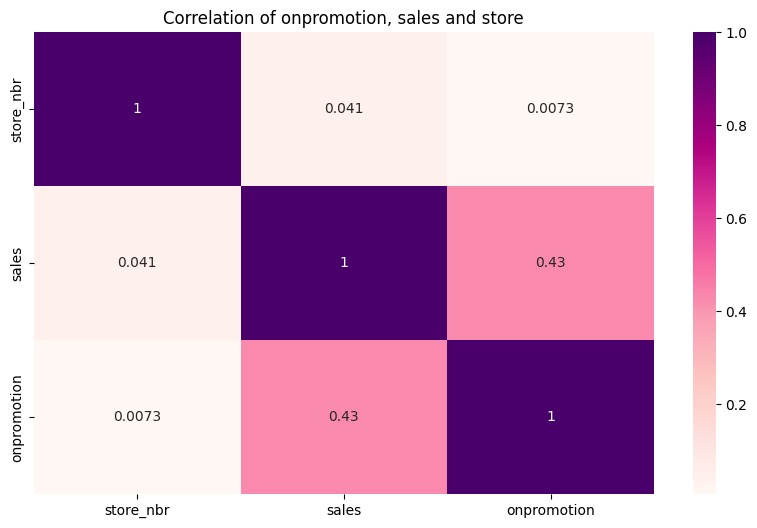

In [34]:
#plotting the correlation of all numeric values
correlation = train.drop(columns = ['family']).corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation, annot=True, cmap = 'RdPu')
plt.title('Correlation of onpromotion, sales and store')
plt.show()

* There is a fairly strong correlation between onpromotion and sales. Let's check the trend and seasonality of onpromotion.

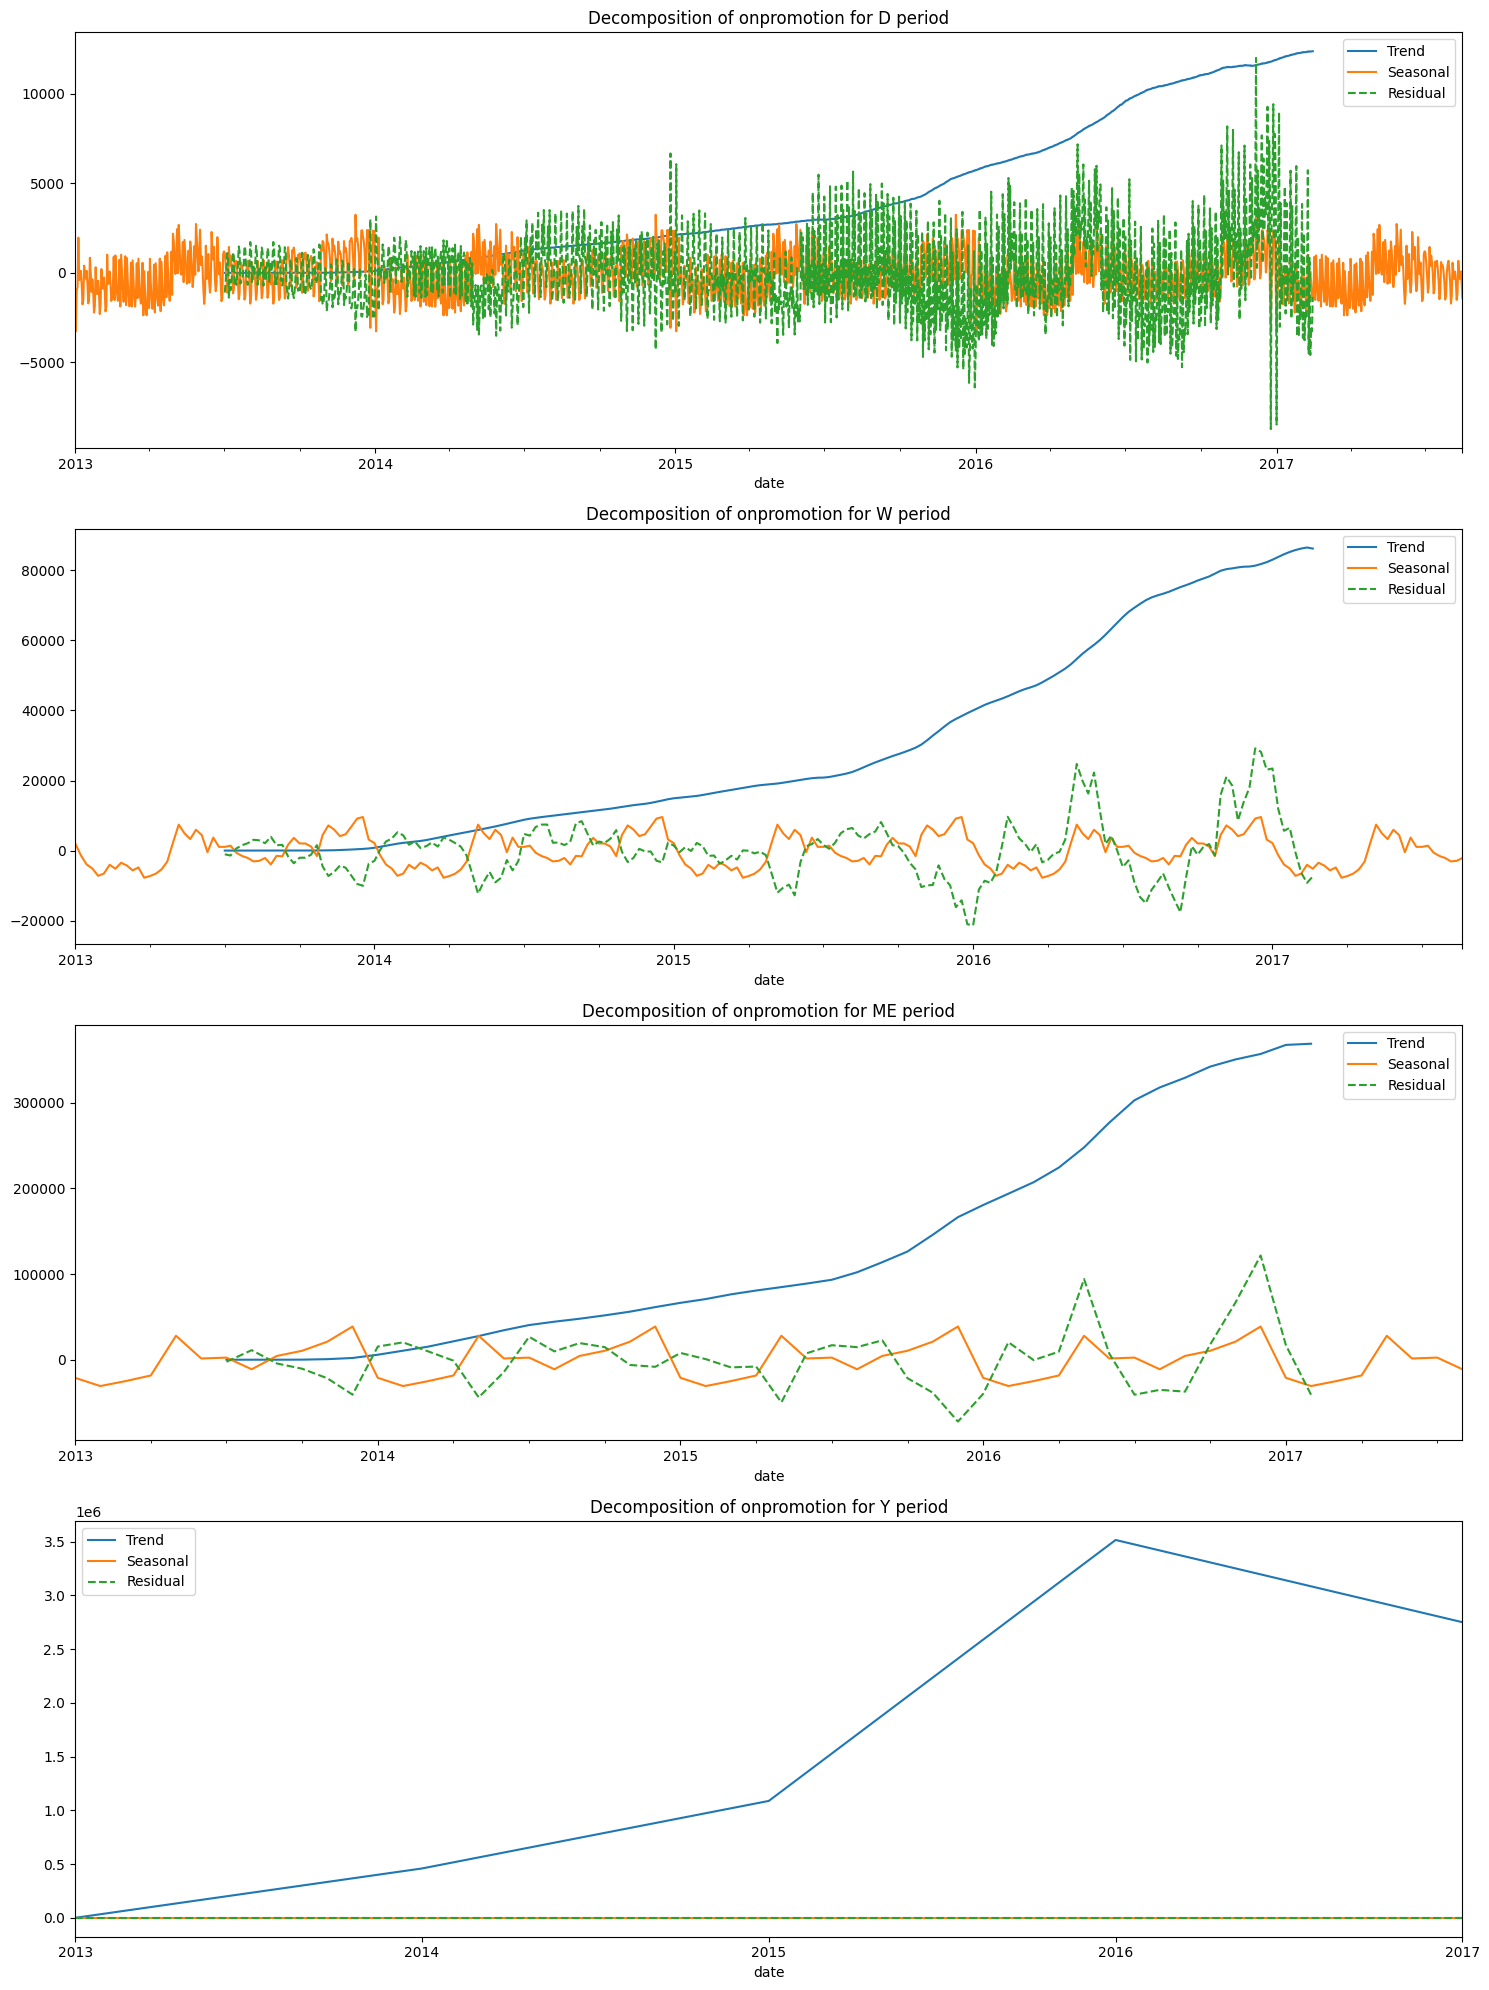

In [68]:
check_seasonality(train,col='onpromotion')

* The trend of onpromotion seems to have an exponential component.
* Onpromotion shows a seasoanlity across weekly and monthly timeframes that has two peaks. 

#### **ANSWERING ANALYTICAL QUESTIONS**

Which date of which year had the highest and lowest sales excluding days when the stores were closed?

In [75]:
# Function to find day with highest and lowest sales across all stores and product families
def highest_lowest_sales_day(df, col='sales'):
    ''' 
    Function to return highest and lowest sales for day when sales were above 0.
    
    df = dataframe to be analysed
    col = column to check max and minimum
    '''
    # Calculating total sales for each day
    daily_sales = df[col].resample('D').sum()
    
    # Finding the day with the highest sales
    highest_sales_day = daily_sales.idxmax().strftime('%Y-%m-%d')
    highest_sales_value = f'${daily_sales.max():,.2f}'  
    # Finding the day with the lowest sales
    lowest_sales_day = daily_sales.idxmin().strftime('%Y-%m-%d')
    lowest_sales_value = f'${daily_sales.min():,.2f}'  
 
    result_df = pd.DataFrame({
        'Highest Sales Day': [highest_sales_day],
        'Highest Sales Value': [highest_sales_value],
        'Lowest Sales Day': [lowest_sales_day],
        'Lowest Sales Value': [lowest_sales_value]
    })
    return result_df

In [76]:
# Calling the function with df_train
sales_summary = highest_lowest_sales_day(train)
sales_summary.T

0
Highest Sales Day       2017-04-01
Highest Sales Value  $1,463,083.96
Lowest Sales Day        2013-12-25
Lowest Sales Value           $0.00

Which are the best performing stores?

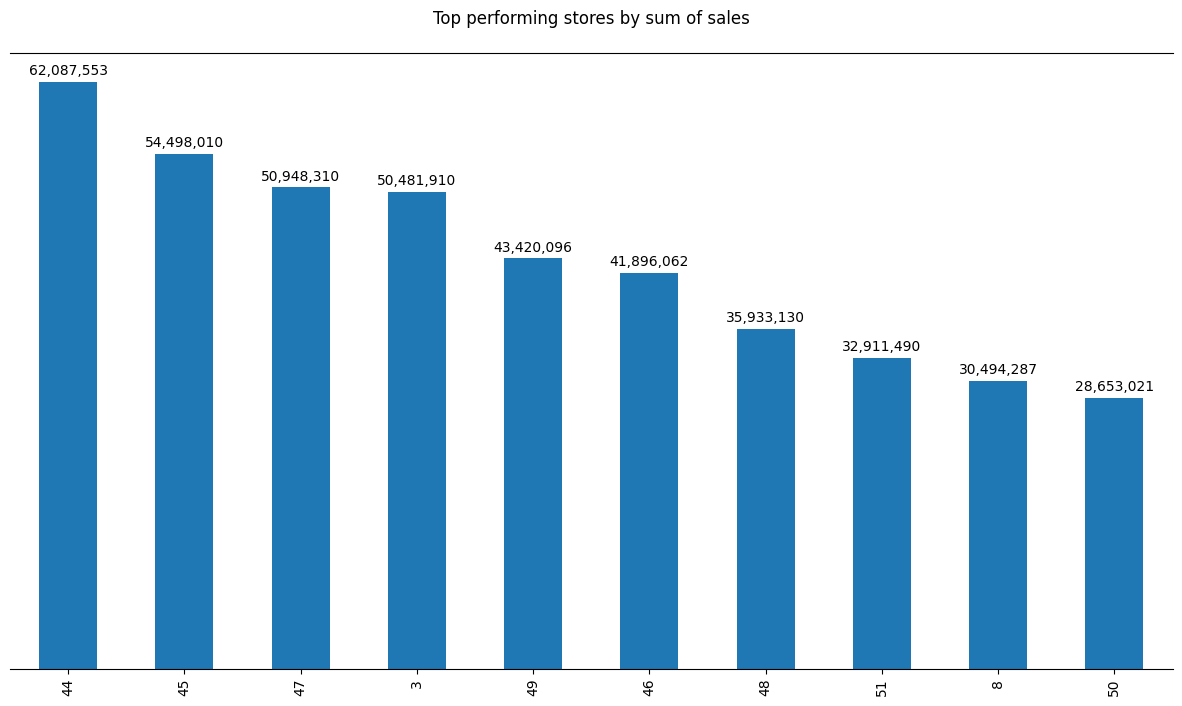

In [97]:
#checking individual stores performance
plt.figure(figsize=(15,8))
ax = train[['sales','store_nbr']].groupby('store_nbr').sales.sum().nlargest(10).sort_values(ascending=False).plot.bar()

for bar in ax.patches:
  ax.annotate(format(bar.get_height(), ',.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
sns.despine(left=True, top=False, right=True)
ax.set(yticklabels=[]) # remove the tick labels
ax.tick_params(left=False) # remove the ticks
plt.ylabel('')
plt.xlabel('')
plt.title('Top performing stores by sum of sales\n')
plt.show()

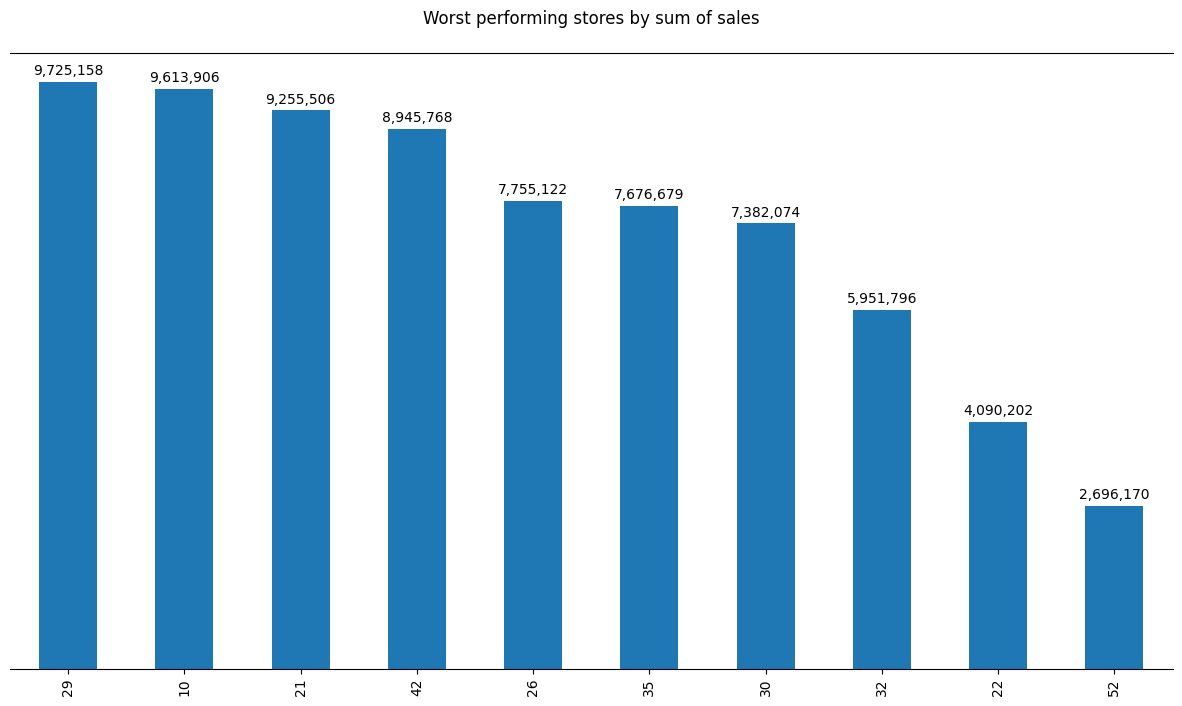

In [98]:
#checking individual stores performance
plt.figure(figsize=(15,8))
ax = train[['sales','store_nbr']].groupby('store_nbr').sales.sum().nsmallest(10).sort_values(ascending=False).plot.bar()

for bar in ax.patches:
  ax.annotate(format(bar.get_height(), ',.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
sns.despine(left=True, top=False, right=True)
ax.set(yticklabels=[]) # remove the tick labels
ax.tick_params(left=False) # remove the ticks
plt.ylabel('')
plt.xlabel('')
plt.title('Worst performing stores by sum of sales\n')
plt.show()

* Store number 44 has the highest sales in all the stores with `$ 62,087,553`.

<Axes: ylabel='family'>

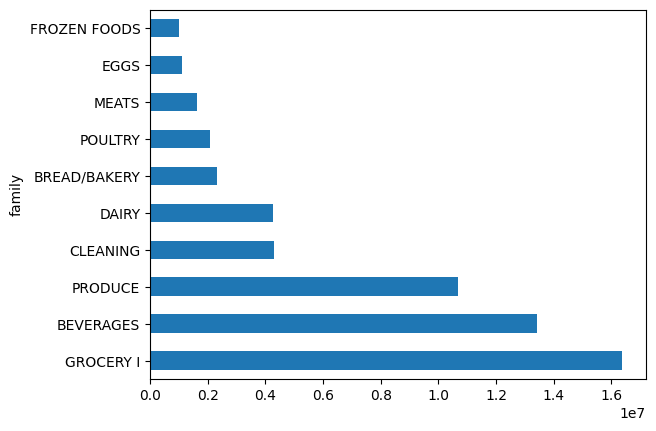

In [103]:
#check which product performs best in store 44
train[train['store_nbr'] == 44].groupby('family').sales.sum().nlargest(10).plot.barh(fig=(10,10))

<Axes: ylabel='family'>

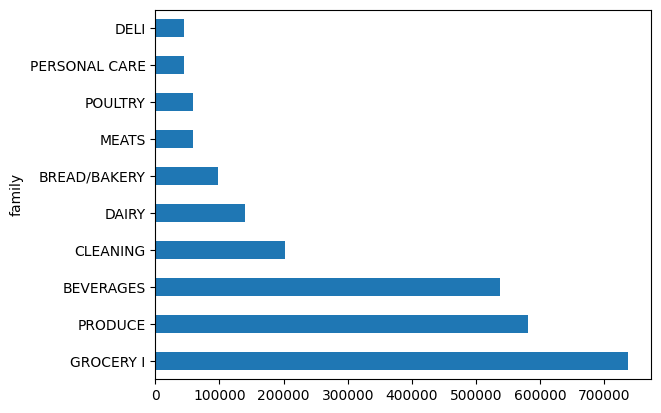

In [102]:
#check which product performs best in store 52
train[train['store_nbr'] == 52].groupby('family').sales.sum().nlargest(10).plot.barh(fig=(10,10))

* Grocery, Beverage, Produce, Cleaning and Dairy maintain the top 5 most sold product families for both the best and worst performing stores. 
* This indicates they are the most popularly sold products.

Decompose the data by different aspects of time, Any patterns?

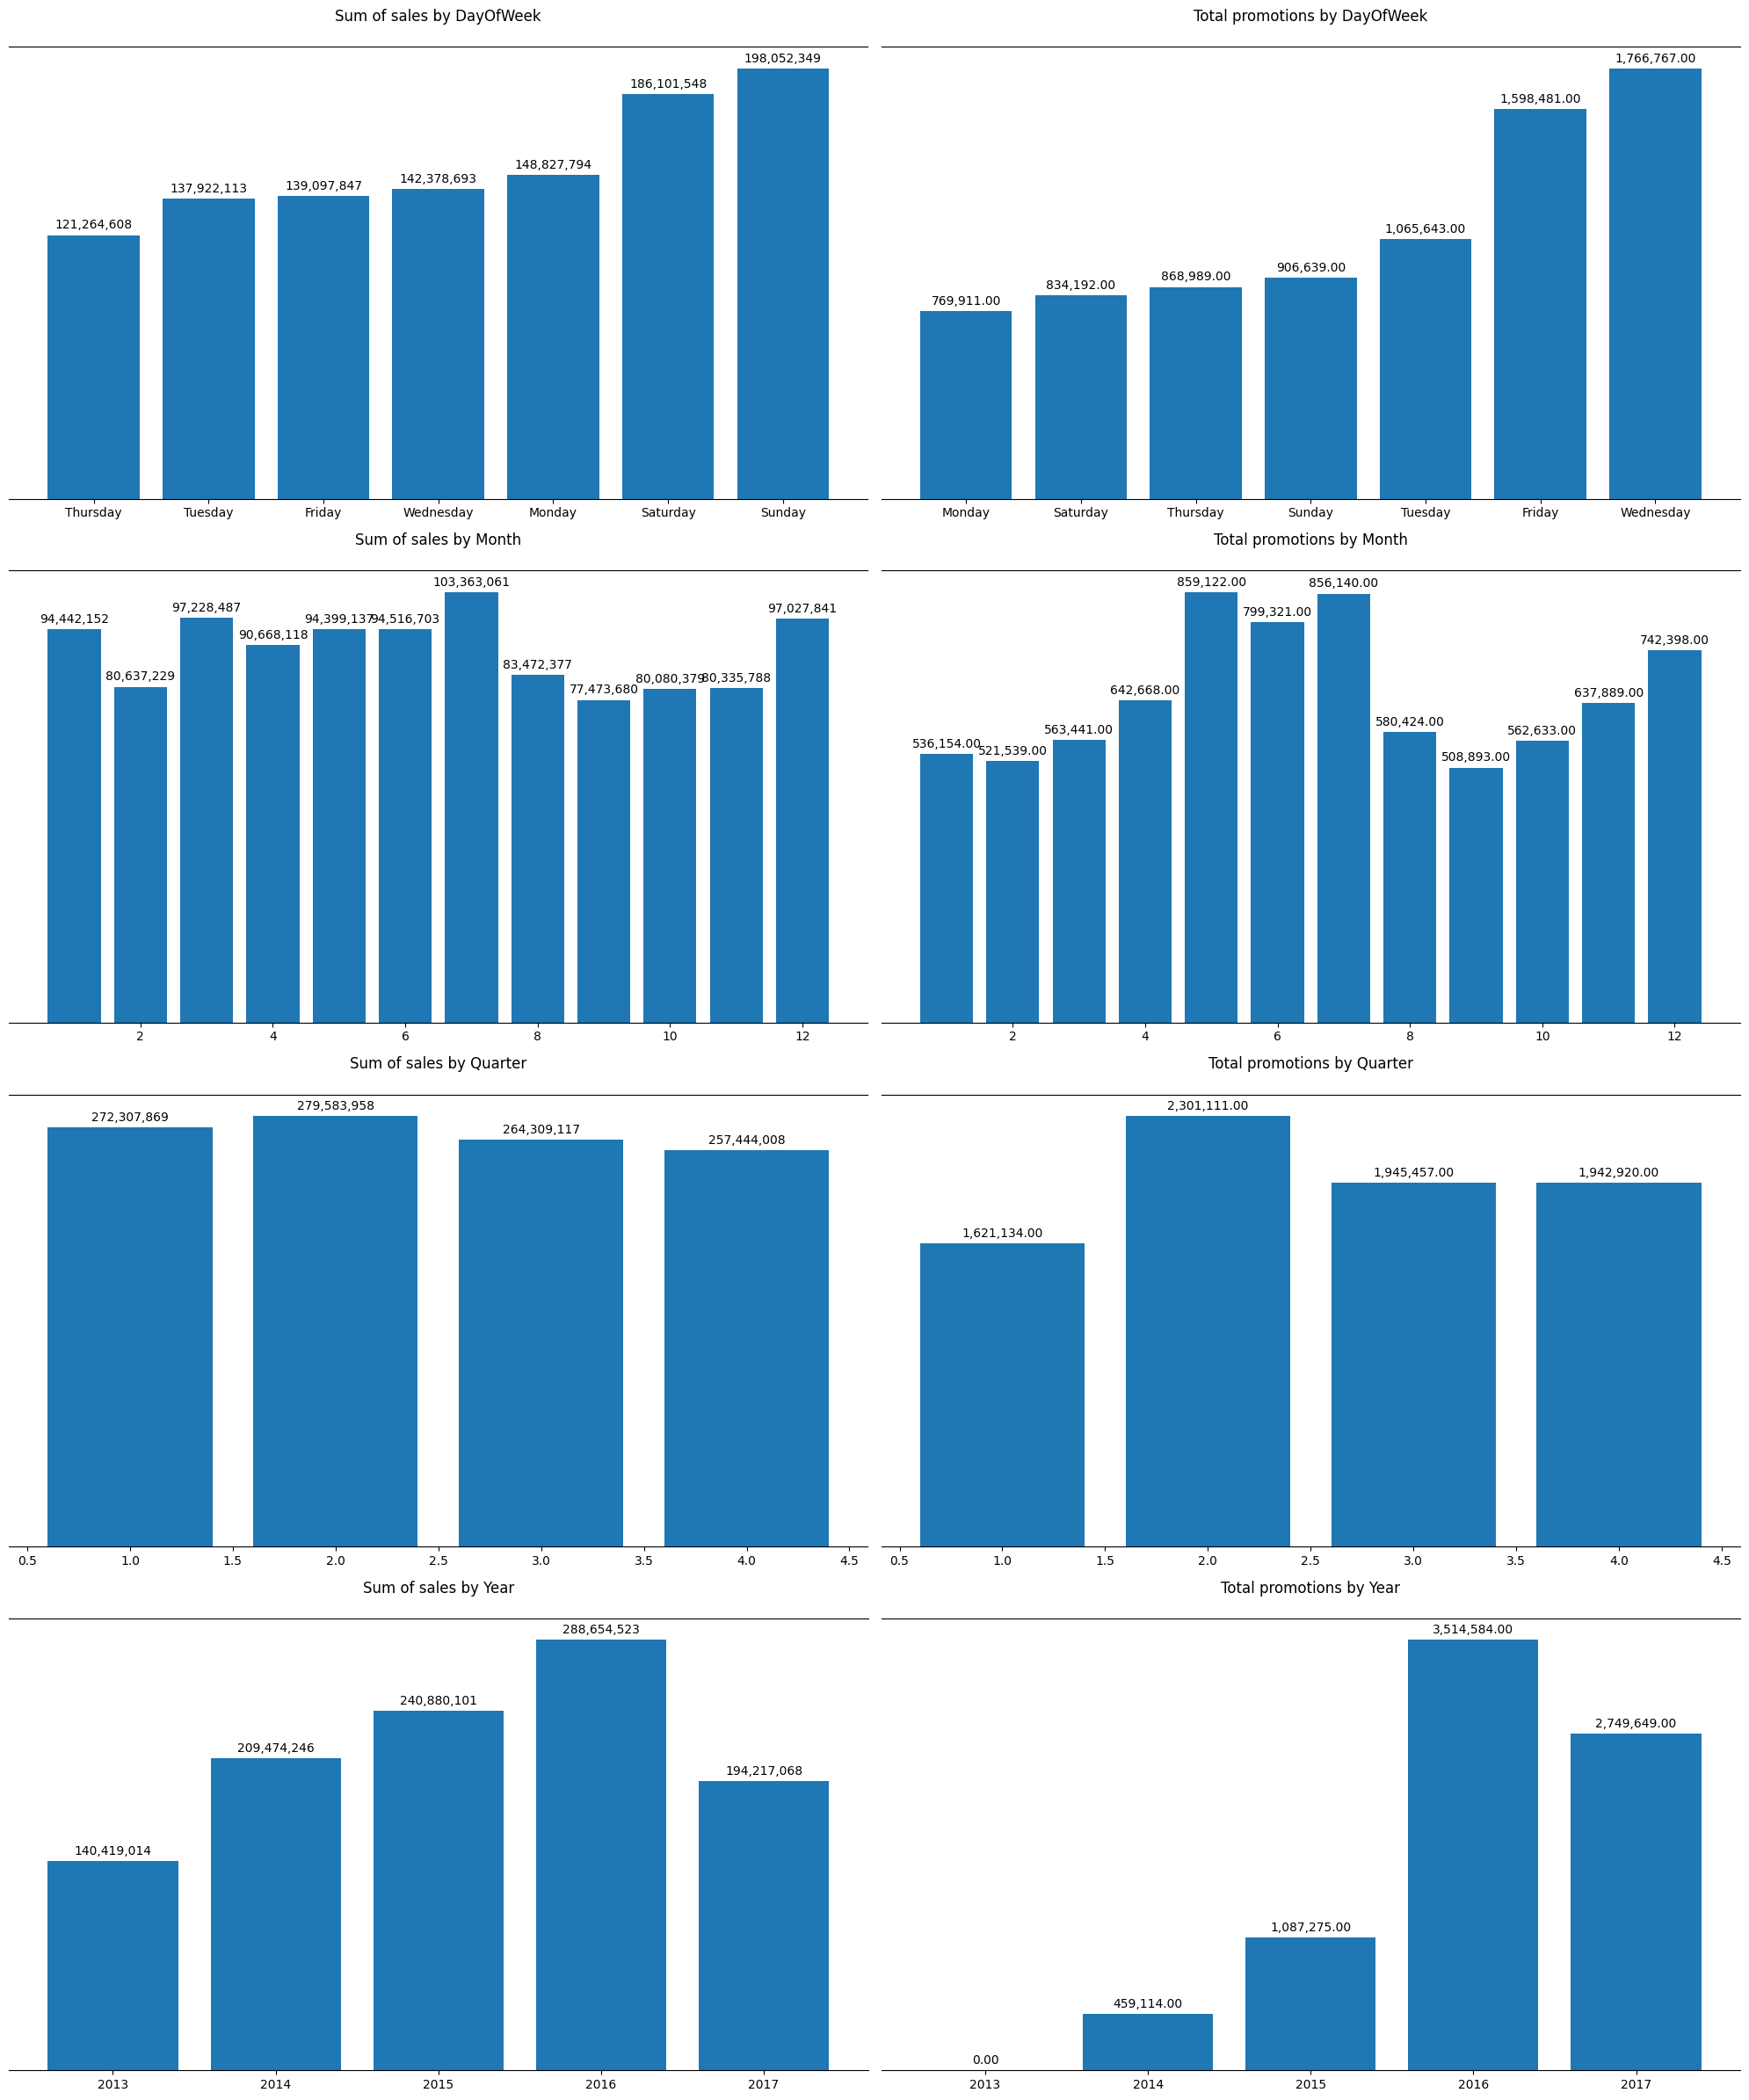

In [37]:
#create new columns by different aspects of time
train['DayOfWeek'] = train.index.day_name()
train['Month'] = train.index.month
train['Quarter'] = train.index.quarter
train['Year'] = train.index.year

#different time periods in a list
time_cols = ['DayOfWeek', 'Month', 'Quarter', 'Year']

#plot for sales and onpromotion for each time period
fig, axs = plt.subplots(4, 2, figsize=(20, 24))

for i, col in enumerate(time_cols):
    data = train[['sales', col]].groupby(col).sum().apply(lambda x: x.sort_values(ascending=True)) #group by sales, aggregate by mean and sort
    axs[i, 0].bar(data.index, data.values.flatten())
    for bar in axs[i, 0].patches:
        axs[i, 0].annotate(format(bar.get_height(), ',.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
    axs[i, 0].set(yticklabels=[]) # remove the tick labels
    axs[i, 0].tick_params(left=False) # remove the ticks
    axs[i, 0].set_title(f'Sum of sales by {col}\n')

    data_1 = train[['onpromotion', col]].groupby(col).sum().apply(lambda x: x.sort_values(ascending=True)) #group by onpromotion, aggregate by mean and sort
    axs[i, 1].bar(data_1.index, data_1.values.flatten())
    for bar in axs[i, 1].patches:
        axs[i, 1].annotate(format(bar.get_height(), ',.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
    axs[i, 1].set(yticklabels=[]) # remove the tick labels
    axs[i, 1].tick_params(left=False) # remove the ticks
    axs[i, 1].set_title(f'Total promotions by {col}\n')

    sns.despine(left=True, top=False, right=True)
    axs[i, 0].set_xlabel('')
    axs[i, 1].set_xlabel('')

plt.tight_layout()
plt.show()

1. `Saturday and Sunday` have the highest total sales in a week, `December` the highest in a year, `4th quarter` the highest in a year and `2017` the highest in the period.
2. `Friday and Wednesday` have the highest average promotions in a week, `December, June and July` the highest in a year, `2nd and 4th` quarters the highest in a year and `2017` the most in the period.

Does the Payment of Wages on 15th and Endmonth affect sales?

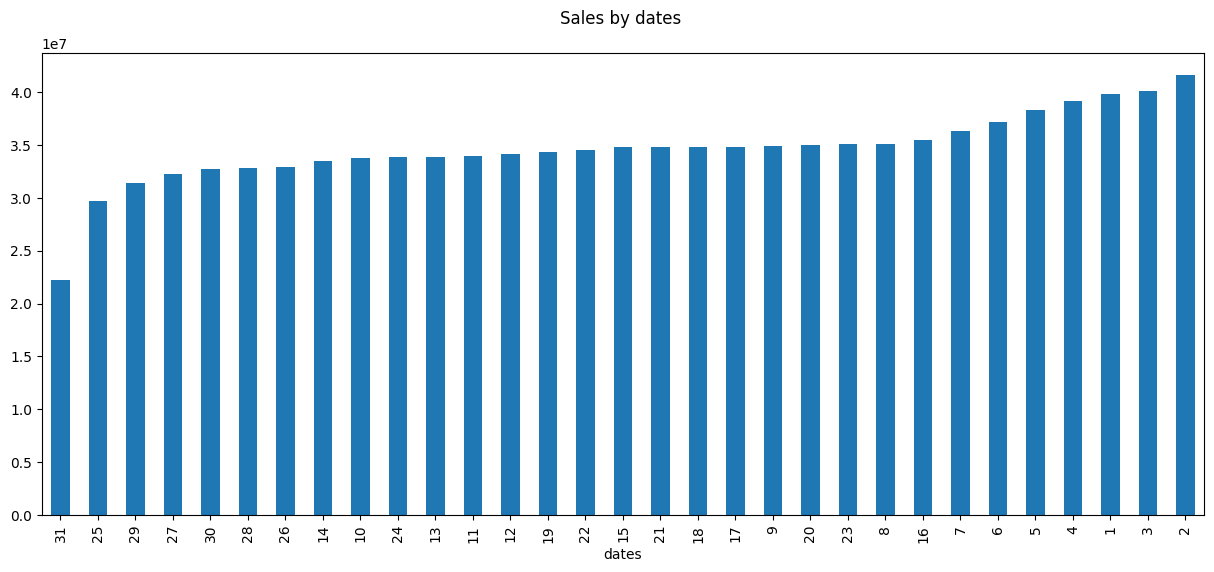

In [38]:
#make the day index
train['dates'] = train.index.day

#check overall sales by date
days = train[['sales','dates']].groupby('dates').sales.sum().sort_values(ascending=True)
ax = days.plot.bar(figsize=(15,6))
plt.title(f'Sales by dates \n')
plt.show() 

* Notice the position of 15th and 31st on the graph.
* Days following 31st have the highest sales in the month and days following 15th aren't in order.

`Impact of 31st Payday on sales`

The sales 5 days before 31st amount to 184,287,010.26$ and 5 days after amount to 199,136,071.70$
This represents a change of 8.06% 


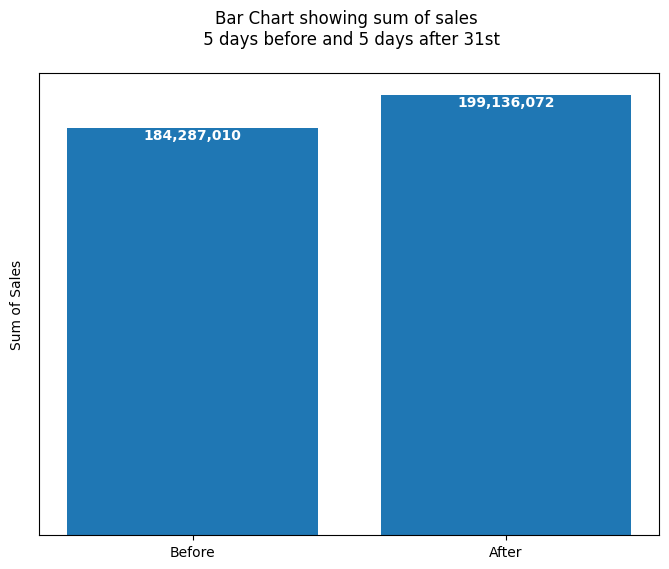

In [39]:
#checking sum of sales before and After 31st of the month
sales_before_31 = train[['family','sales']][(train['dates'] > 25)] #sales 5 days before 31 inclusive.

sales_after_31 = train[['family','sales']][(train['dates'] < 6)] #sales 5 days after 31 exclusive

#Sum sales before and after 31st
check=[(sales_before_31['sales'].sum()),(sales_after_31['sales'].sum())]

print(f"The sales 5 days before 31st amount to {(check[0]):,.2f}$ and 5 days after amount to {(check[1]):,.2f}$")
print(f"This represents a change of {(check[1] - check[0])/(check[0])*100:,.2f}% ")


#plot balance of sales
plt.figure(figsize=(8,6))
plt.bar(x=['Before','After'], height=check)

#annotate bars
for i, v in enumerate(check):
    plt.text(i, v, f"{v:,.0f}", ha="center", va='top', fontweight='bold', color='white')

plt.title(f'Bar Chart showing sum of sales \n 5 days before and 5 days after 31st\n')
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.tick_params(left=False)
plt.ylabel('Sum of Sales')
plt.show()

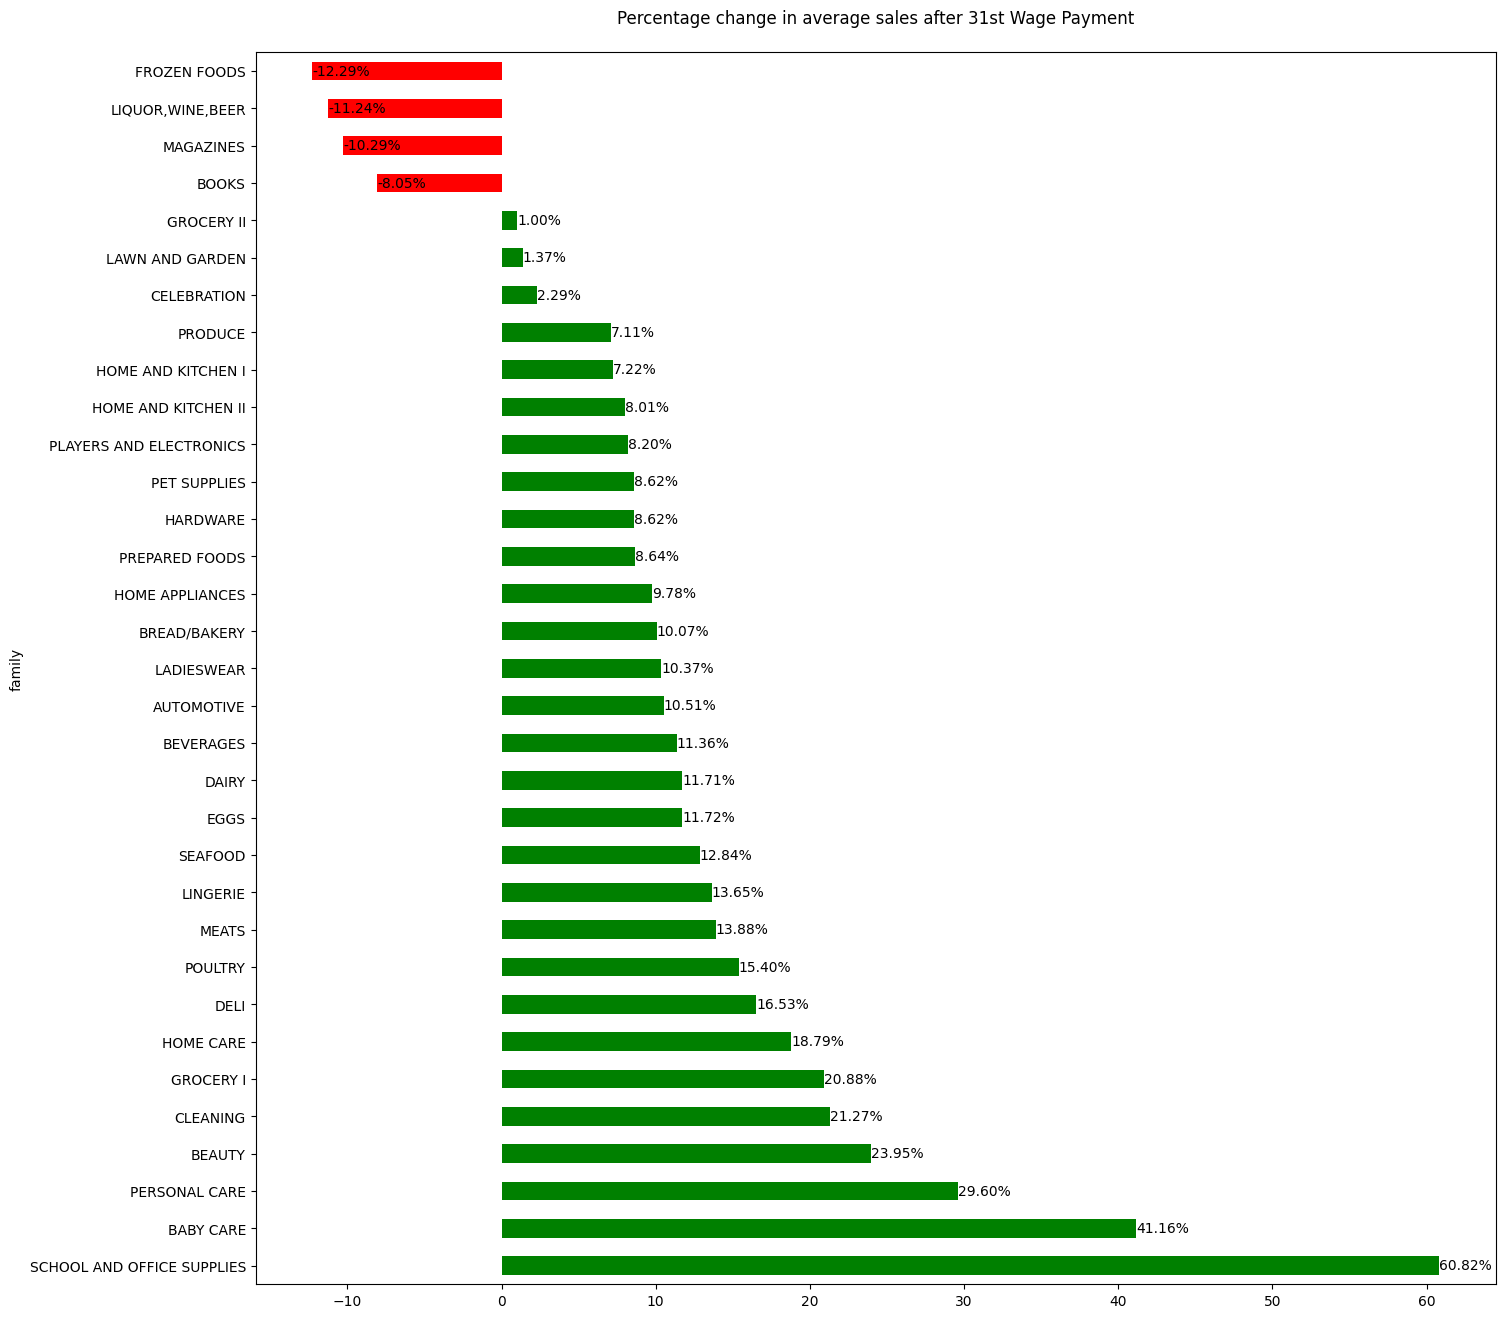

In [40]:
#create dataframe for sales before and after 31st 
family_trend = pd.DataFrame({'before':(sales_before_31.groupby('family').sales.mean()),'after':(sales_after_31.groupby('family').sales.mean())})

#create column for the change in demand before and after 31st payday in percentage
for item in enumerate(family_trend.index):
    family_trend['pct_change'] = (((family_trend['after'] - family_trend['before'])/family_trend['before'])*100)

#select the pct_change and sorting in descending order
changes = family_trend.sort_values('pct_change', ascending=False)['pct_change'] 

#plot the pct_changes in sales
clrs = ['green' if (x > 0) else 'red' for x in changes ]

plt.figure(figsize = (16,16))

ax = changes.plot.barh(color=clrs)

for p in ax.patches: #annotate the bars
    width = p.get_width()
    ax.text(width, p.get_y() + p.get_height() / 2, 
            f"{width:.2f}%", ha="left", va="center")

plt.title(f'Percentage change in average sales after 31st Wage Payment\n')

plt.show()

* The wage payment on 31st has a positive impact on sales. 
* The payment increases sales of `School and office supplies`, `Baby care` and `Personal care` the **most** while simultaneously reducing demand for `frozen foods`, `liquor` and `magazines`.

`Impact of 15th Payday on Sales`

The sales 5 days before 15th amount to 170,375,938.25$ and 5 days after amount to 139,499,261.41$
This represents a change of -18.12% 


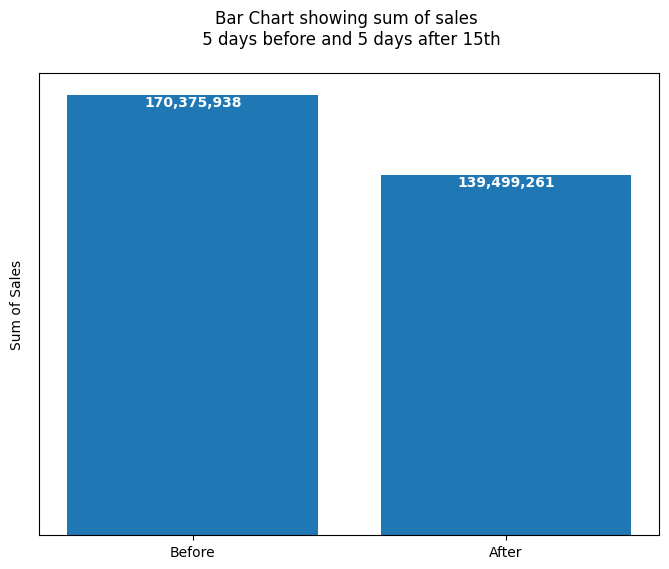

In [41]:
#checking sum of sales before and After 15th of the month
sales_before_15 = train[['family','sales']][(train['dates'] > 10) & (train['dates'] < 16)] #sales 5 days before 15th inclusive.

sales_after_15 = train[['family','sales']][(train['dates'] > 15) & (train['dates'] < 20)] #sales 5 days after 15th exclusive

#Sum sales before and after 15th
check_15=[(sales_before_15['sales'].sum()),(sales_after_15['sales'].sum())]

print(f"The sales 5 days before 15th amount to {(check_15[0]):,.2f}$ and 5 days after amount to {(check_15[1]):,.2f}$")
print(f"This represents a change of {(check_15[1] - check_15[0])/(check_15[0])*100:,.2f}% ")

#plot balance of sales
plt.figure(figsize=(8,6))
plt.bar(x=['Before','After'], height=check_15)

#annotate bars
for i, v in enumerate(check_15):
    plt.text(i, v, f"{v:,.0f}", ha="center", va='top', fontweight='bold', color='white')

plt.title(f'Bar Chart showing sum of sales \n 5 days before and 5 days after 15th\n')
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.tick_params(left=False)
plt.ylabel('Sum of Sales')
plt.show()

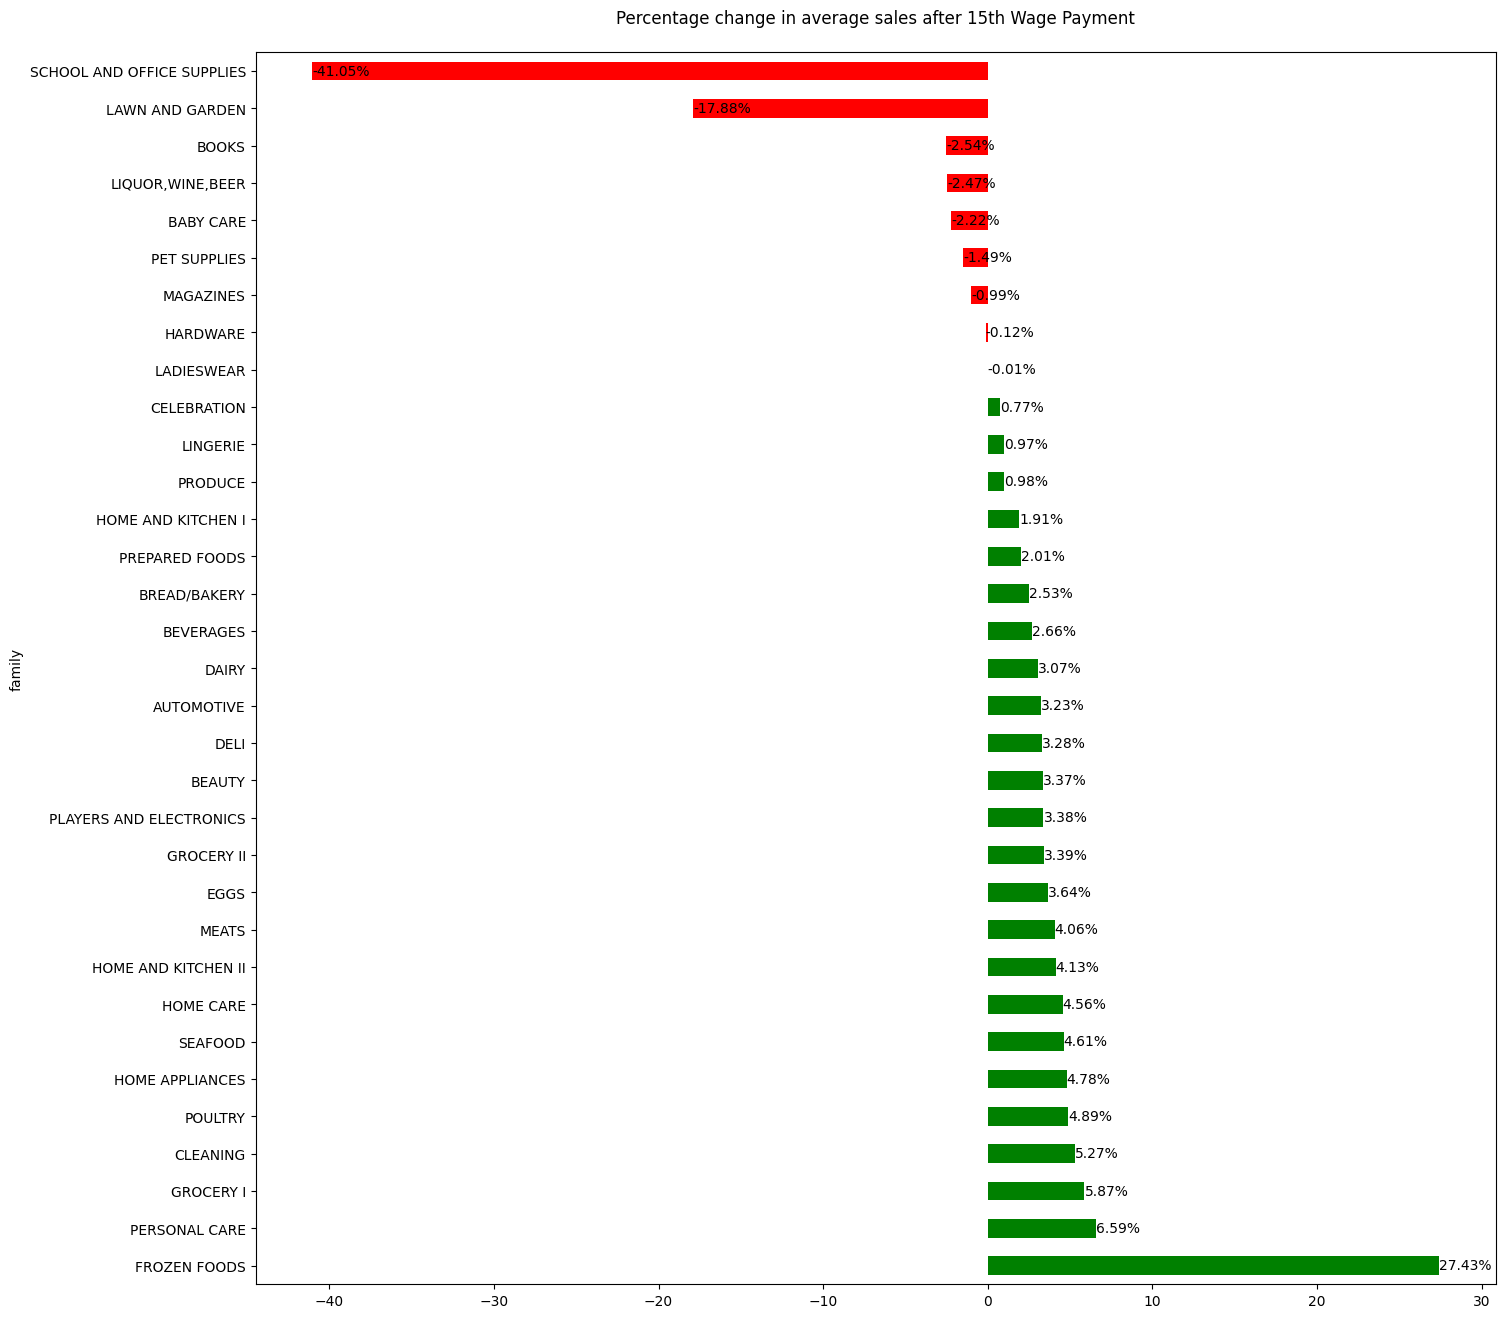

In [42]:
#create dataframe for sales before and after 31st 
family_trend_15 = pd.DataFrame({'before':(sales_before_15.groupby('family').sales.mean()),'after':(sales_after_15.groupby('family').sales.mean())})

#create column for the change in demand before and after 31st payday in percentage
for item in enumerate(family_trend_15.index):
    family_trend_15['pct_change'] = (((family_trend_15['after'] - family_trend_15['before'])/family_trend_15['before'])*100)

#select the pct_change and sorting in descending order
changes_15 = family_trend_15.sort_values('pct_change', ascending=False)['pct_change'] 

#plot the pct_changes in sales
clrs = ['green' if (x > 0) else 'red' for x in changes_15 ]

plt.figure(figsize = (16,16))

ax = changes_15.plot.barh(color=clrs)

for p in ax.patches: #annotate the bars
    width = p.get_width()
    ax.text(width, p.get_y() + p.get_height() / 2, 
            f"{width:.2f}%", ha="left", va="center")

plt.title(f'Percentage change in average sales after 15th Wage Payment\n')


plt.show()

* The wage payment on 15th has an overall negative impact on sales.
* Across some product families especially `frozen foods` sales increase by `27.43%`. The most negatively impacted are `School and office supplies` and `Lawn and Garden`.

Are certain stores or clusters selling more?

In [104]:
with_stores = pd.merge(train, stores, on='store_nbr', how='inner') #merge with store data
with_stores

store_nbr                      family  sales  onpromotion   city  \
0                1                  AUTOMOTIVE   0.00            0  Quito   
1                1                   BABY CARE   0.00            0  Quito   
2                1                      BEAUTY   0.00            0  Quito   
3                1                   BEVERAGES   0.00            0  Quito   
4                1                       BOOKS   0.00            0  Quito   
...            ...                         ...    ...          ...    ...   
3008011          9                     POULTRY   0.00            0  Quito   
3008012          9              PREPARED FOODS   0.00            0  Quito   
3008013          9                     PRODUCE   0.00            0  Quito   
3008014          9  SCHOOL AND OFFICE SUPPLIES   0.00            0  Quito   
3008015          9                     SEAFOOD   0.00            0  Quito   

             state type  cluster  
0        Pichincha    D       13  
1        Pichincha    D       13  
2        Pichincha    D       13  
3        Pichincha    D       13  
4        Pichincha    D       13  
...            ...  ...      ...  
3008011  Pichincha    B        6  
3008012  Pichincha    B        6  
3008013  Pichincha    B        6  
3008014  Pichincha    B        6  
3008015  Pichincha    B        6  

[3008016 rows x 8 columns]

Sales by Type, Cluster, City and State

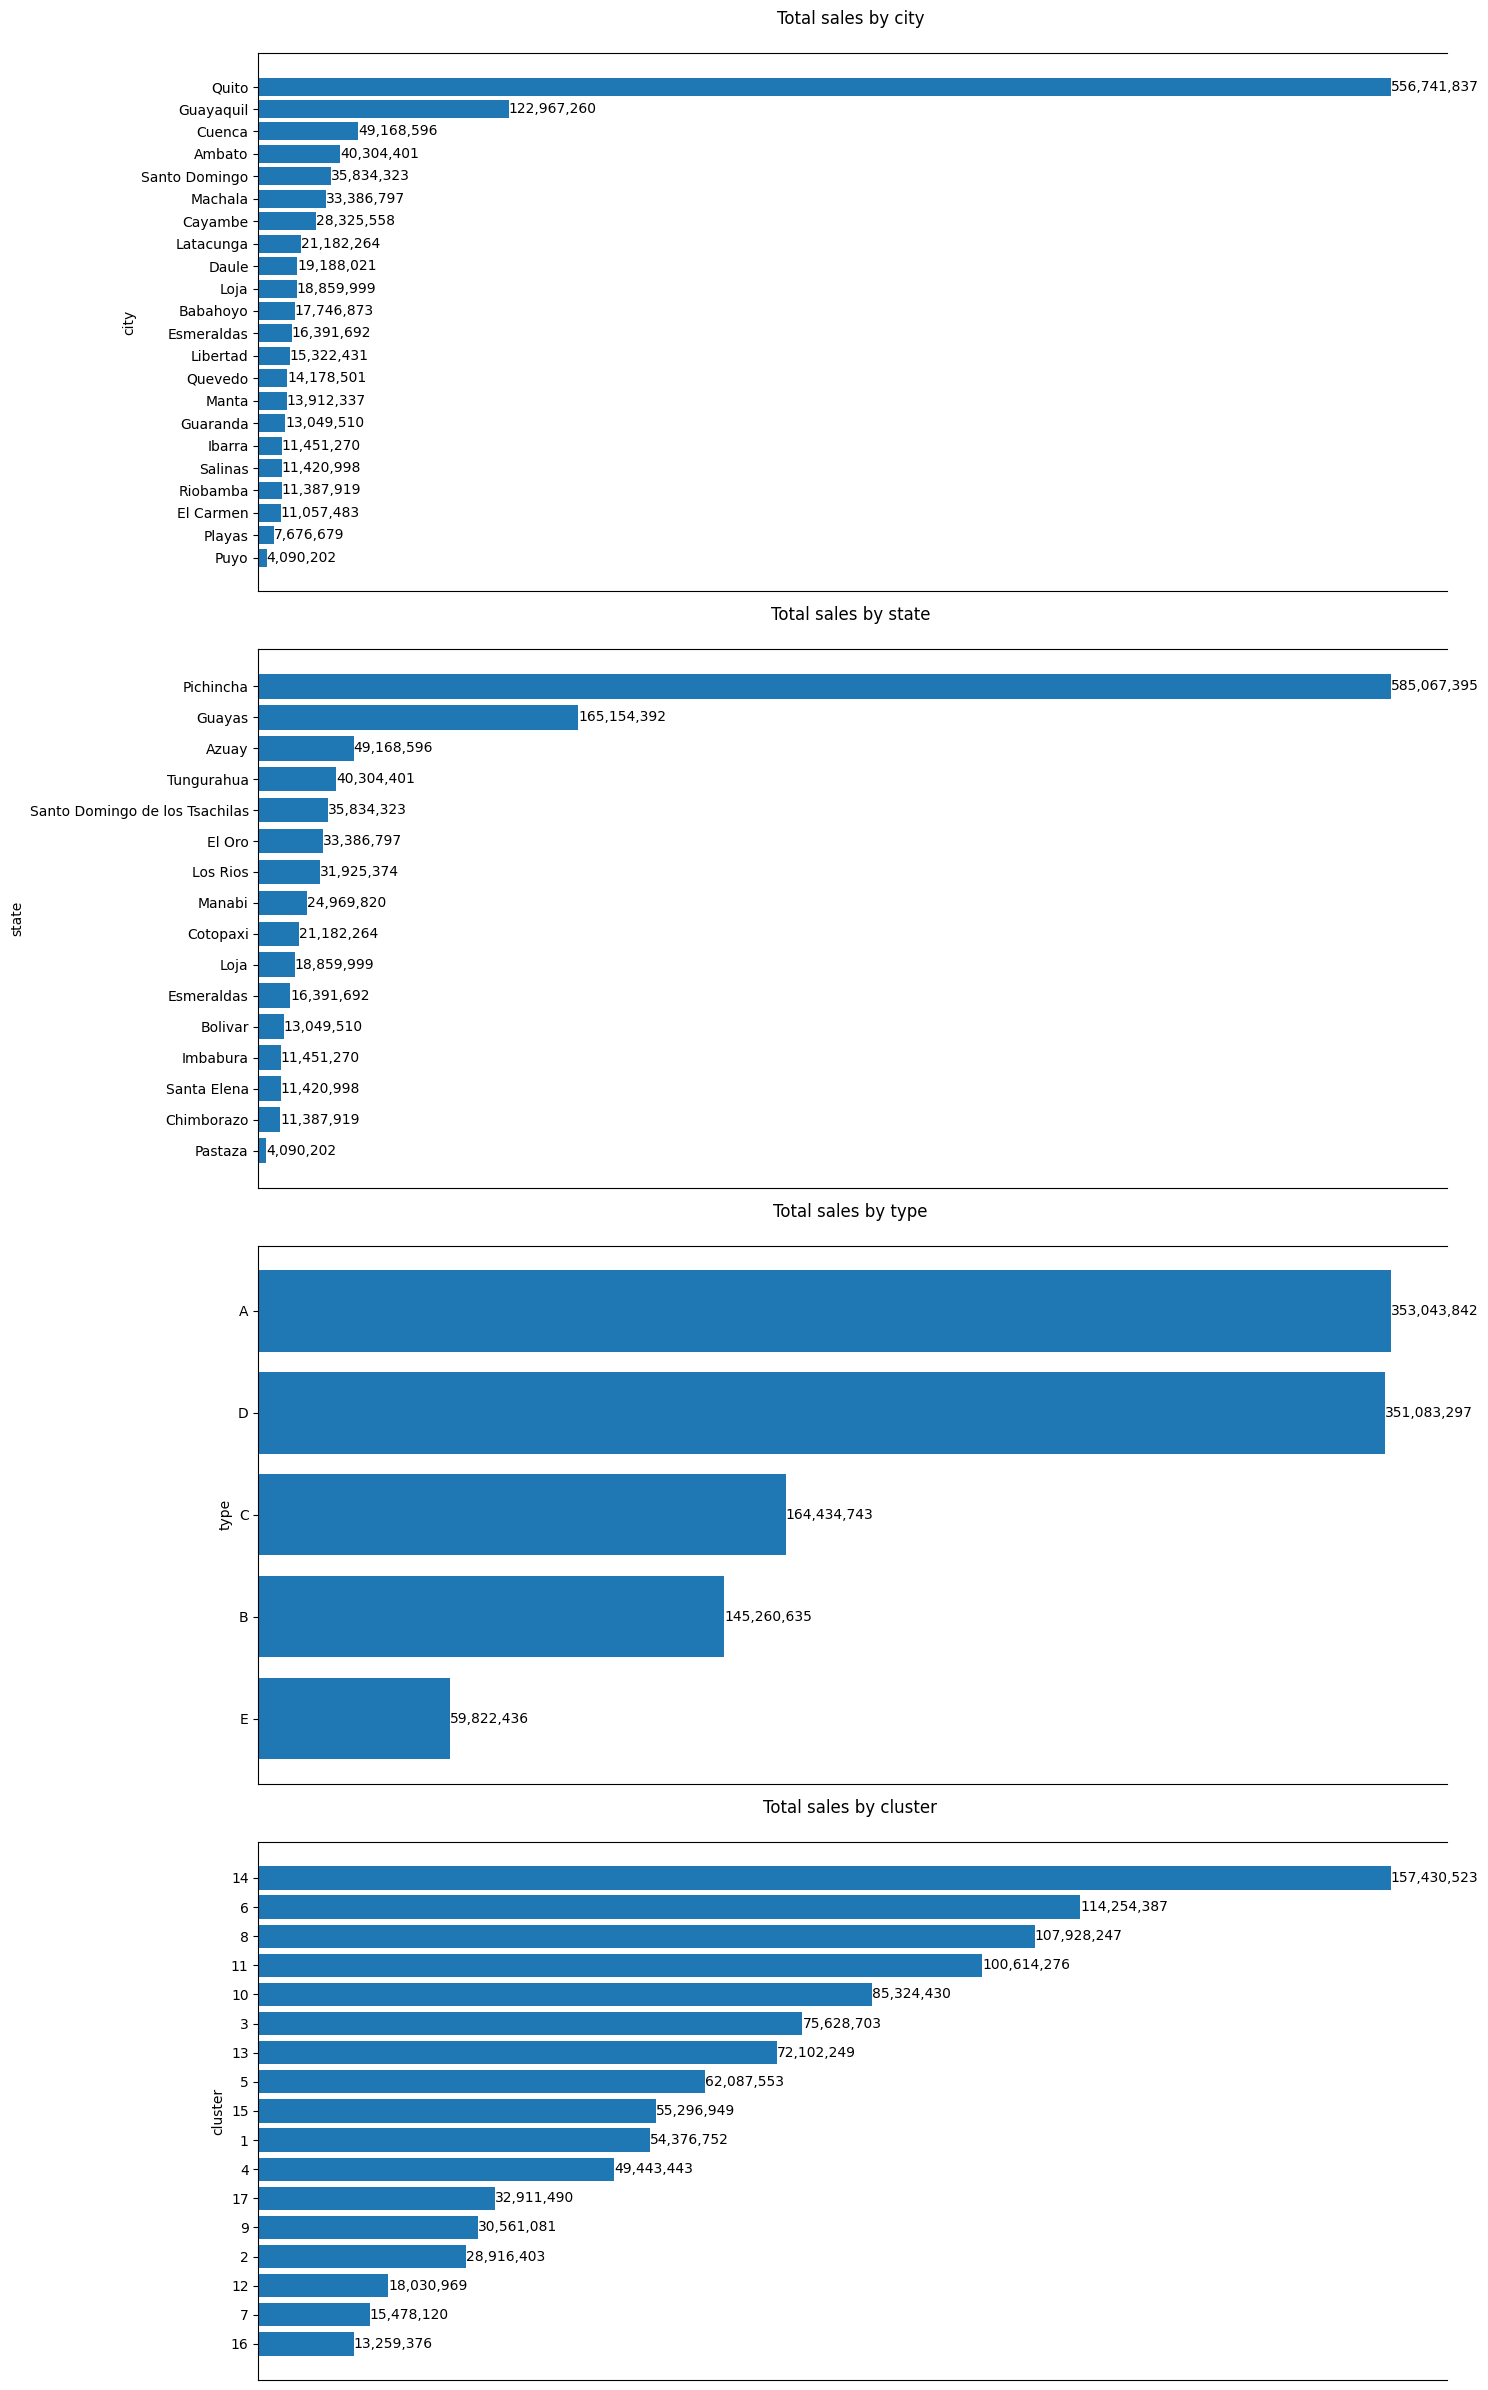

In [45]:
groups = ['city','state','type','cluster']

fig, axs = plt.subplots(4,1, figsize=(15,24))

#plot total sales by city, state, type and cluster
for i, group in enumerate(groups):
    grouped_data = with_stores[['sales', group]].groupby(group).sales.sum().sort_values(ascending=True)
    grouped_data.index = grouped_data.index.astype(str)
    axs[i].barh(grouped_data.index, grouped_data.values)
    axs[i].bar_label(axs[i].containers[0], fmt='{:,.0f}')
    sns.despine(right=True, top=False)
    axs[i].set(xticklabels=[])
    axs[i].tick_params(bottom=False)
    axs[i].set_title(f'Total sales by {group} \n')
    axs[i].set_xlabel('')
    axs[i].set_ylabel(group)

plt.tight_layout()
plt.show() 

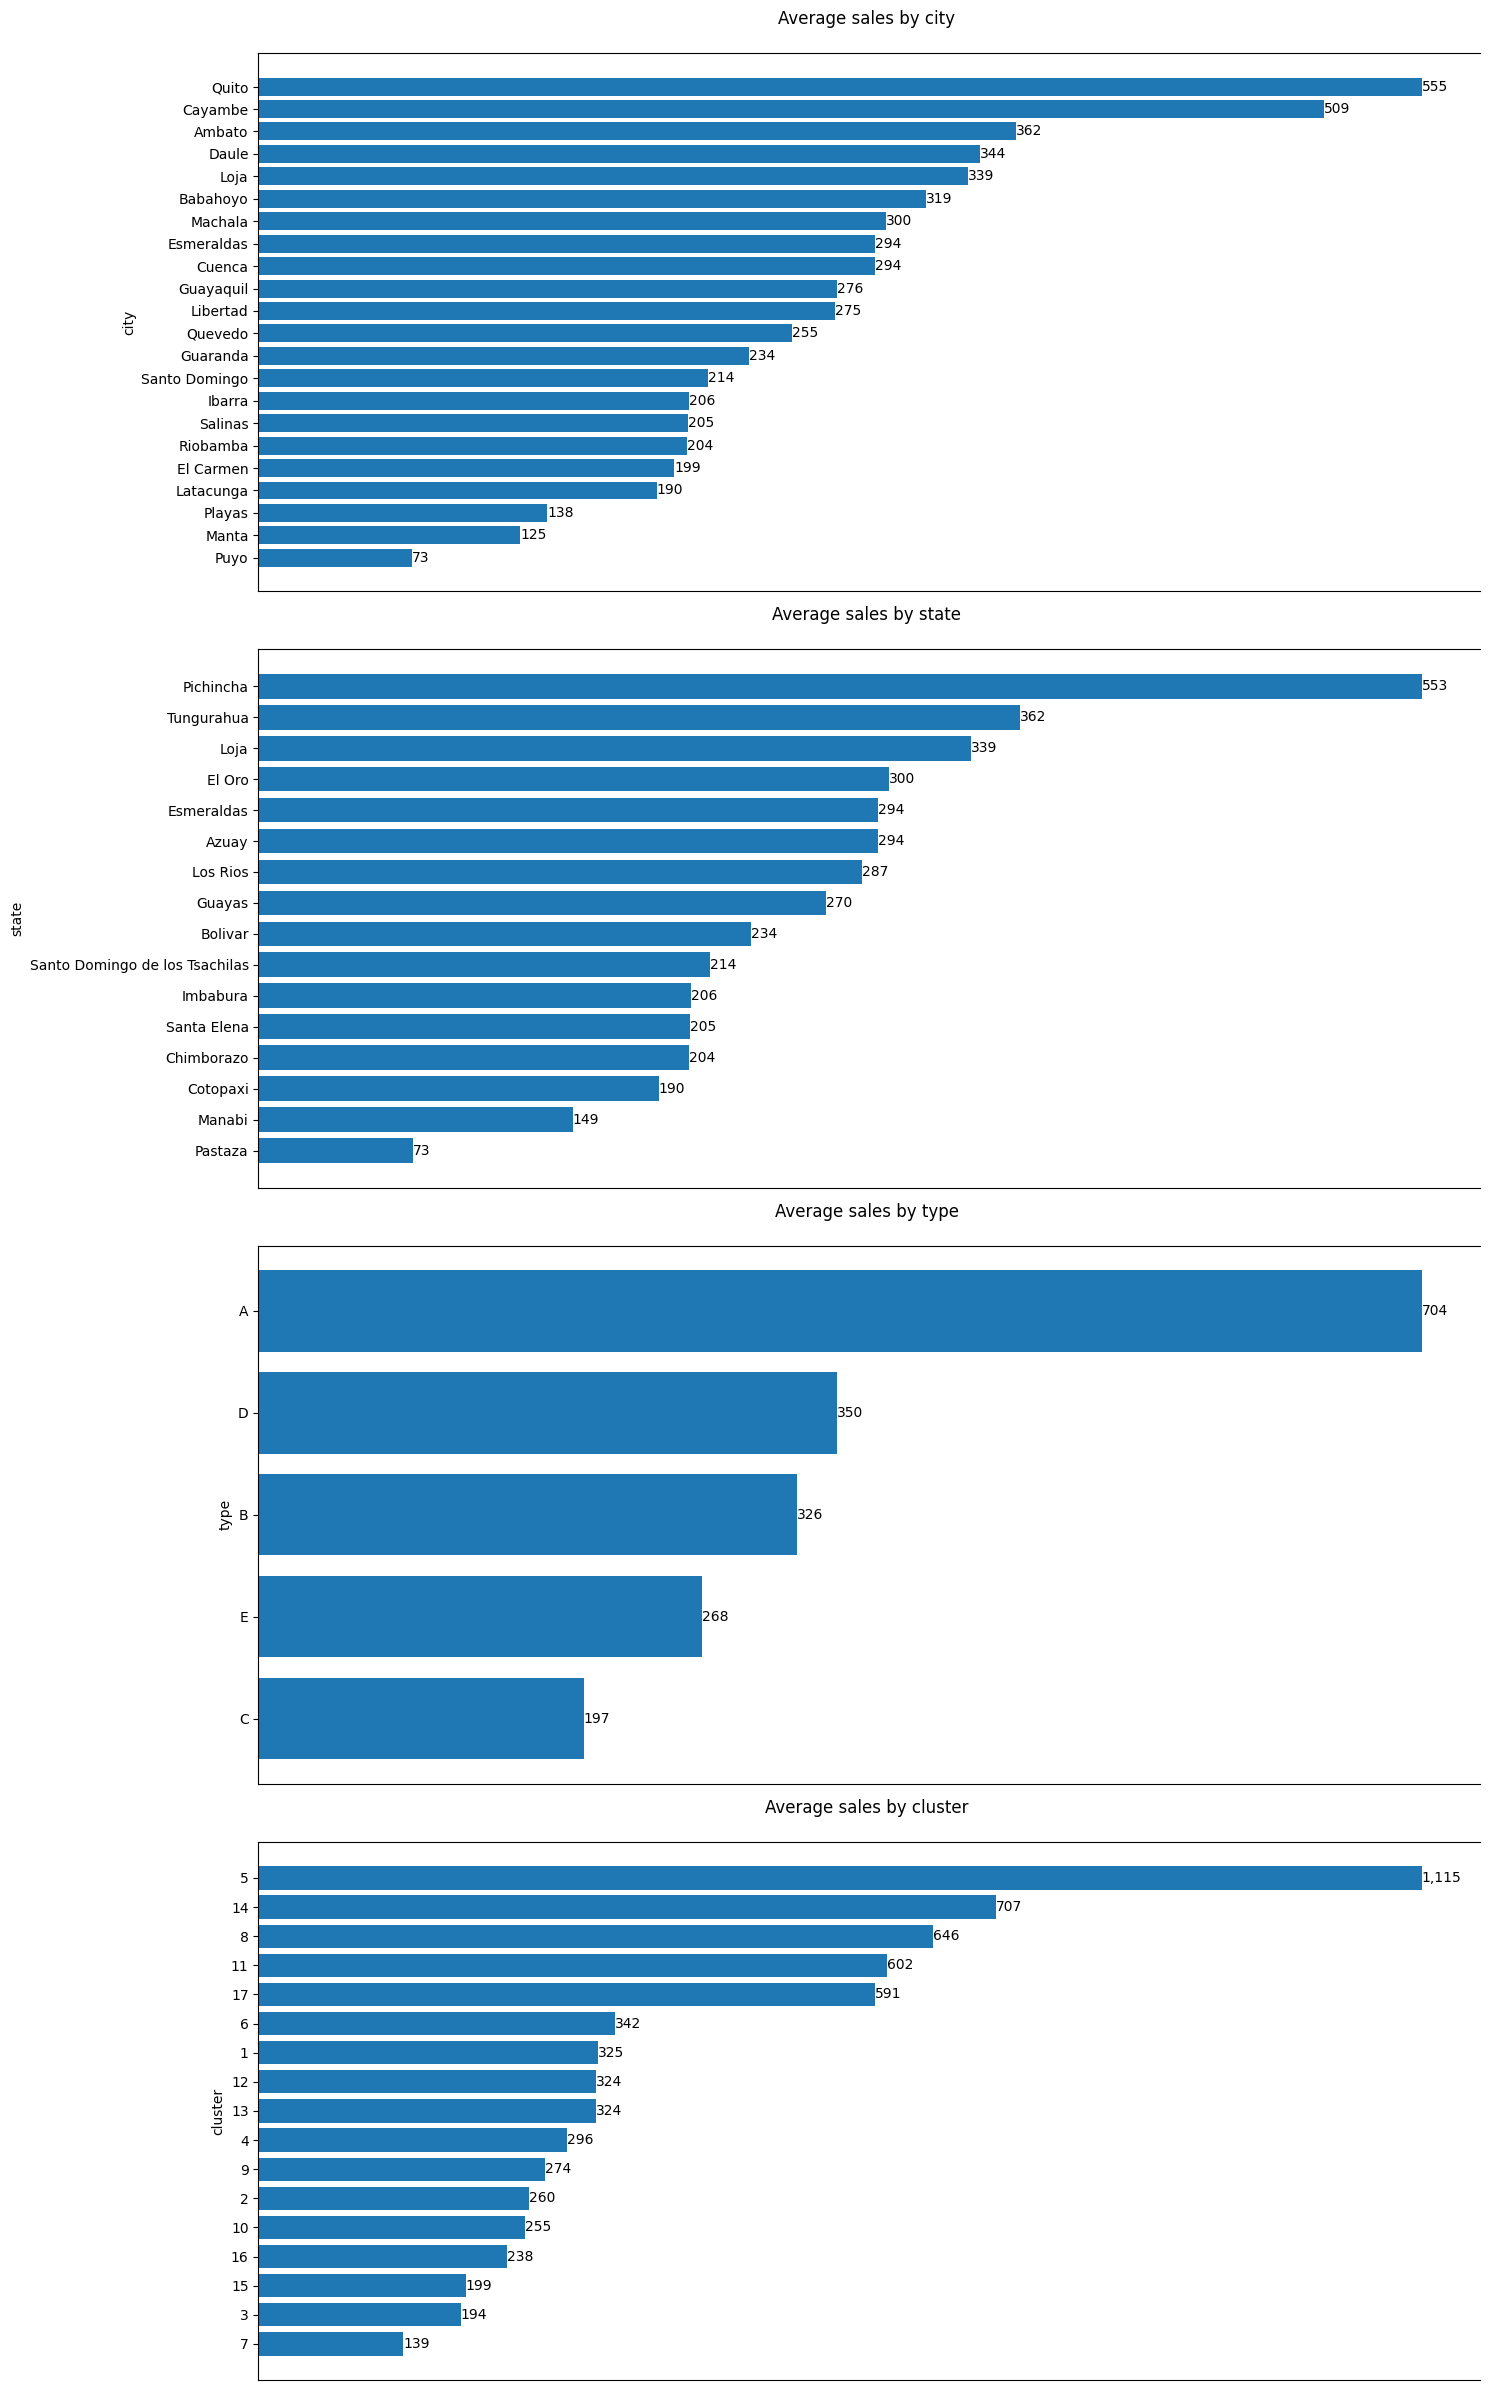

In [46]:
fig, axs = plt.subplots(4,1, figsize=(15,24))

#plot average sales by city, state, type and cluster
for i, group in enumerate(groups):
    grouped_data = with_stores[['sales', group]].groupby(group).sales.mean().sort_values(ascending=True)
    grouped_data.index = grouped_data.index.astype(str)
    axs[i].barh(grouped_data.index, grouped_data.values)
    axs[i].bar_label(axs[i].containers[0], fmt='{:,.0f}')
    axs[i].set(xticklabels=[])
    axs[i].tick_params(bottom=False)
    axs[i].set_title(f'Average sales by {group} \n')
    axs[i].set_xlabel('')
    axs[i].set_ylabel(group)
    sns.despine(right=True, top=False)

plt.tight_layout()
plt.show()

* The stores that have the best performance by sum of sales, are not necessarily the ones that have the highest average sale value. 
* This could indicate impact of extrogenous features such as population, income, preferences etc. in the different locations.

In [47]:
# Check most sold product family for each cluster

# extract only the sales, cluster and family columns
cluster_sales = pd.DataFrame(with_stores.groupby(['cluster','family']).sales.sum()).reset_index()

#create dictionary for cluster_top family
cluster_tops = pd.DataFrame(columns = ['cluster','family','sales']).set_index('cluster')

# iterate over cluster_sales
for cluster in cluster_sales['cluster'].unique():
    highest_sale = cluster_sales.loc[cluster]['sales'].max()
    top_family = cluster_sales[cluster_sales['sales'] == highest_sale]['family'].values[0]
    cluster_tops.loc[cluster] = {'family':top_family,'sales':highest_sale}

cluster_tops

family         sales
cluster                                   
1                  BABY CARE        191.00
2                     BEAUTY     18,200.00
3                  BEVERAGES 11,765,234.00
4                      BOOKS        452.00
5               BREAD/BAKERY  2,659,815.07
6                CELEBRATION     42,331.00
7                   CLEANING  3,988,665.00
8                      DAIRY  3,930,158.00
9                       DELI  1,058,732.39
10                      EGGS    879,584.00
11              FROZEN FOODS    909,511.89
12                 GROCERY I 14,539,464.00
13                GROCERY II     99,125.00
14                  HARDWARE      6,229.00
15        HOME AND KITCHEN I     76,456.00
16       HOME AND KITCHEN II     90,188.00
17           HOME APPLIANCES      1,362.00

Different clusters have different top product family. 

Promotion and Sales

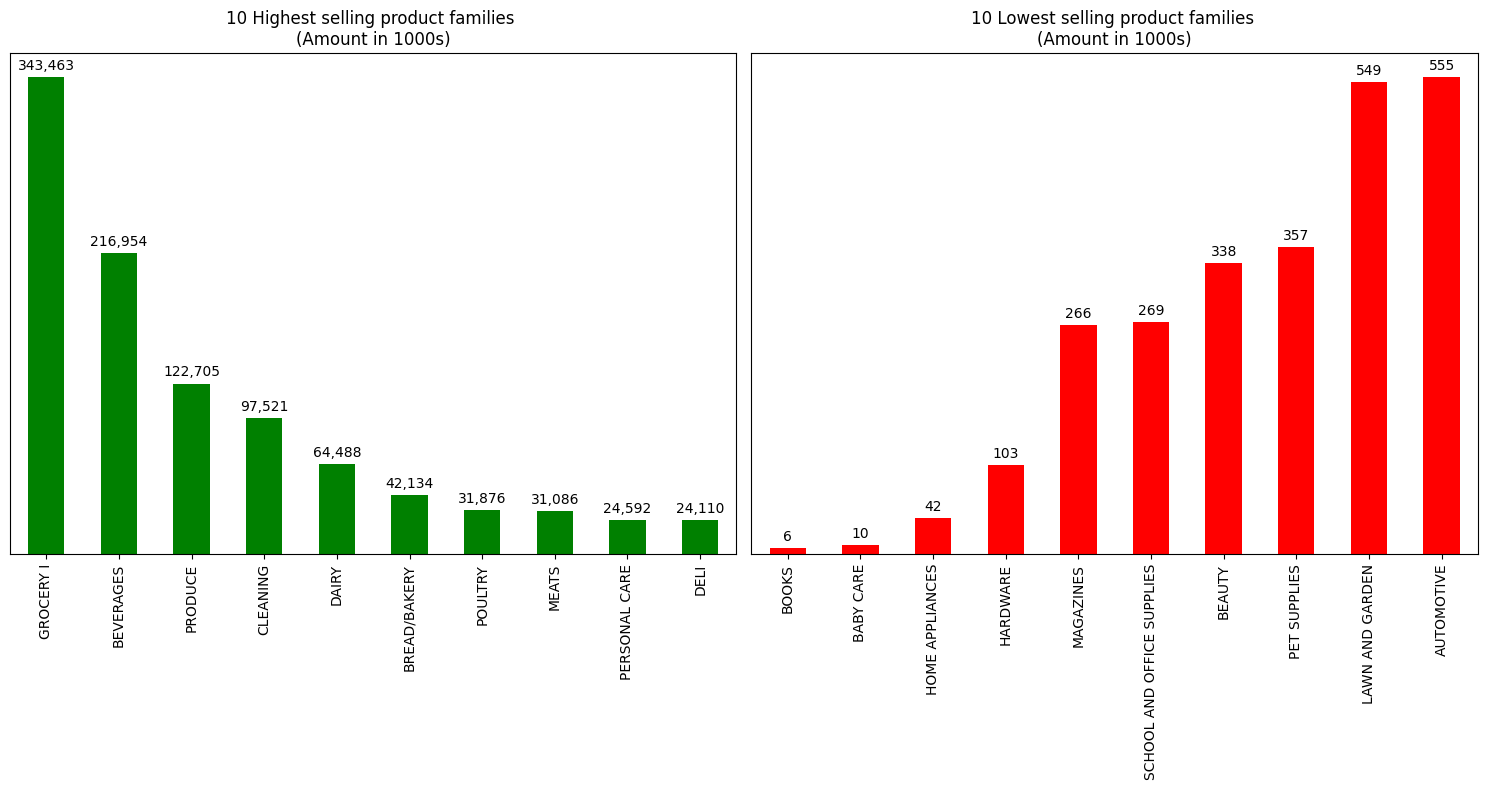

In [48]:
#checking the family with the most sales
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Top 10 selling product families
ax = train.groupby('family').sales.sum().nlargest(10).plot.bar(ax=axs[0], color='green')
for bar in axs[0].patches:
  axs[0].annotate(format((bar.get_height()/1000).round(), ',.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
axs[0].set(yticklabels=[])
axs[0].tick_params(left=False) # remove the ticks
axs[0].set_ylabel('')
axs[0].set_xlabel('')
axs[0].set_title('10 Highest selling product families \n(Amount in 1000s)')

# Bottom 10 selling product families
ax = train.groupby('family').sales.sum().nsmallest(10).plot.bar(ax=axs[1], color='red')
for bar in axs[1].patches:
  axs[1].annotate(format((bar.get_height()/1000).round(), ',.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
axs[1].set(yticklabels=[])
axs[1].tick_params(left=False) # remove the ticks
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[1].set_title('10 Lowest selling product families \n(Amount in 1000s)')

#sns.despine(left=True, top=False, right=True)

plt.tight_layout()
plt.show()

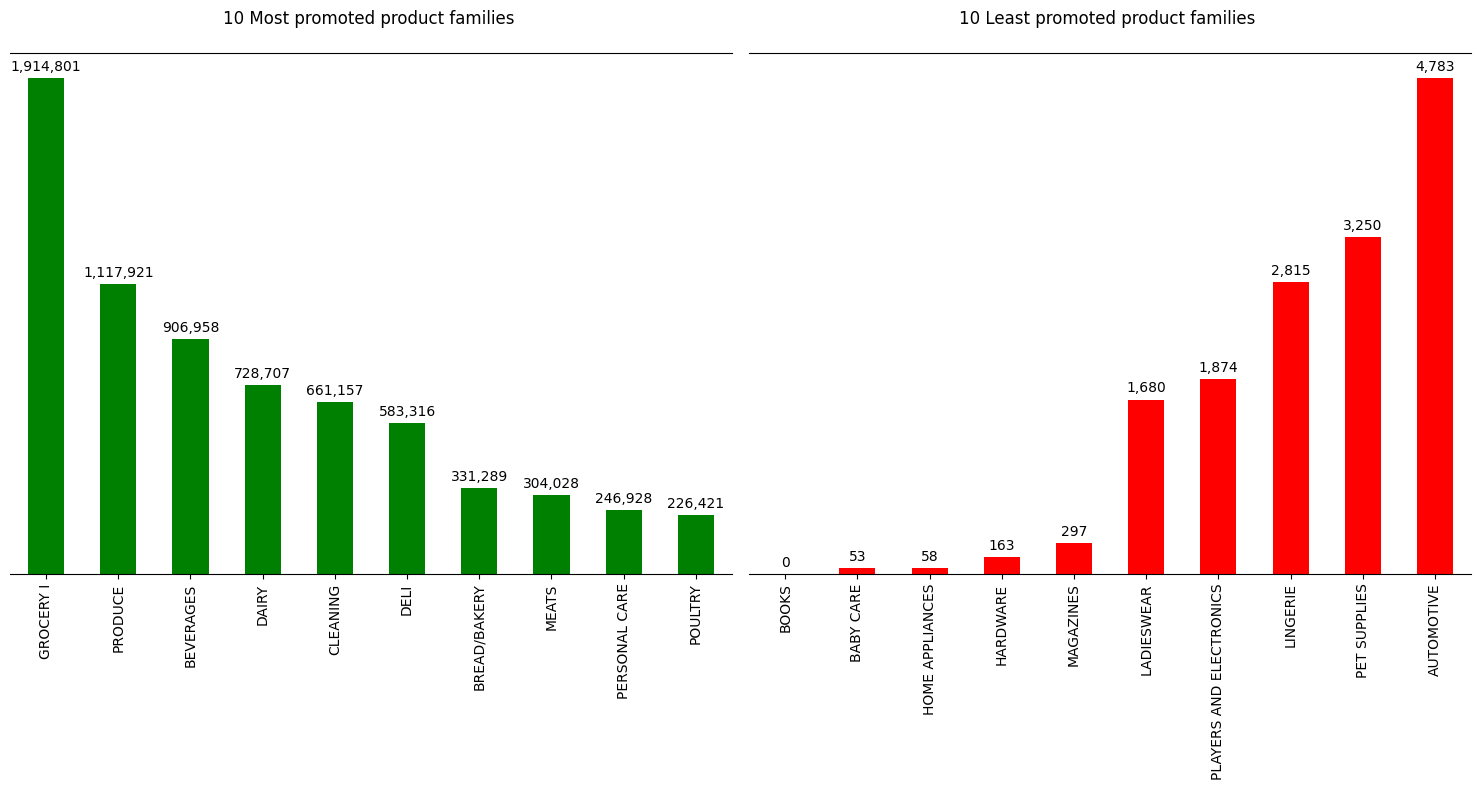

In [49]:
#checking the most promoted products
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Top 10 selling product families
ax = train.groupby('family').onpromotion.sum().nlargest(10).plot.bar(ax=axs[0], color='green')
for bar in axs[0].patches:
  axs[0].annotate(format(bar.get_height(), ',.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
axs[0].set(yticklabels=[])
axs[0].tick_params(left=False) # remove the ticks
axs[0].set_ylabel('')
axs[0].set_xlabel('')
axs[0].set_title('10 Most promoted product families \n')

# Bottom 10 selling product families
ax = train.groupby('family').onpromotion.sum().nsmallest(10).plot.bar(ax=axs[1], color='red')
for bar in axs[1].patches:
  axs[1].annotate(format(bar.get_height(), ',.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
axs[1].set(yticklabels=[])
axs[1].tick_params(left=False) # remove the ticks
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[1].set_title('10 Least promoted product families \n')

sns.despine(left=True, top=False, right=True)

plt.tight_layout()
plt.show()

The products that were most promoted were the best performing and `70%` of those that weren't promoted were the least performing. This confirms the correlation observed earlier of `0.43`

Oil and Sales

In [50]:
#set date as index in oil dataset
oil['date'] = pd.to_datetime(oil['date'])
oil = oil.set_index('date')
oil

dcoilwtico
date                  
2013-01-01         NaN
2013-01-02       93.14
2013-01-03       92.97
2013-01-04       93.12
2013-01-07       93.20
...                ...
2017-08-25       47.65
2017-08-28       46.40
2017-08-29       46.46
2017-08-30       45.96
2017-08-31       47.26

[1218 rows x 1 columns]

In [51]:
#checking for oil data completeness
start_date = oil.index.min()
end_date = oil.index.max()
print(f'The data starts on {start_date} and ends on {end_date}, accounting for {end_date - start_date} days\n')

date_range = pd.date_range(start_date, end_date)
print(f'{date_range}\n')

missing_days_oil = date_range.difference(oil.index)
print(f'These are the missing_days in the data \n{missing_days_oil}\n')

The data starts on 2013-01-01 00:00:00 and ends on 2017-08-31 00:00:00, accounting for 1703 days 00:00:00 days

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30', '2017-08-31'],
              dtype='datetime64[ns]', length=1704, freq='D')

These are the missing_days in the data 
DatetimeIndex(['2013-01-05', '2013-01-06', '2013-01-12', '2013-01-13',
               '2013-01-19', '2013-01-20', '2013-01-26', '2013-01-27',
               '2013-02-02', '2013-02-03',
               ...
               '2017-07-29', '2017-07-30', '2017-08-05', '2017-08-06',
               '2017-08-12', '2017-08-13', '2017-08-19', '2017-08-20',
               '2017-08-26', '2017-08-27'],
      

* The oil dataset has more days than the train dataset, we will drop the days beyond the max train date.
* The oil data has missing dates that follow each other, check which days they are and impute accordingly.

In [52]:
#drop the dates beyond the max train date
for index in  oil.index:
    if index > train.index.max():
        oil = oil.drop(index)
    
oil.index.max()

Timestamp('2017-08-15 00:00:00')

In [53]:
#check which days are missing
days = []

for date in missing_days_oil:
    days.append(date.day_name()) #create a list of the days of missing data

unique_days = list(set(days)) #check only the unique days in the list
print(f'The missing days are {unique_days}.')
print(f'There are a total of {len(days)} missing dates.')


The missing days are ['Sunday', 'Saturday'].
There are a total of 486 missing dates.


Oil markets are closed on saturday and sunday, we will impute the data by backfilling the price of Friday. 

In [54]:
#create new datafame with data for missing dates
new_oil = pd.DataFrame(columns=['date','dcoilwtico']).set_index('date')
new_oil = oil.reindex(missing_days_oil, method='bfill') #use backfilling for oil price
new_oil

dcoilwtico
2013-01-05       93.20
2013-01-06       93.20
2013-01-12       94.27
2013-01-13       94.27
2013-01-19         NaN
...                ...
2017-08-13       47.59
2017-08-19         NaN
2017-08-20         NaN
2017-08-26         NaN
2017-08-27         NaN

[486 rows x 1 columns]

In [55]:
#concating with the oil data
filled_oil = pd.concat([oil,new_oil])
missing_ = date_range.difference(filled_oil.index) #confirming no missing dates remain
missing_

DatetimeIndex(['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-21',
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
              dtype='datetime64[ns]', freq=None)

In [56]:
#merge with the train data
with_oil = pd.merge(train.reset_index(), filled_oil.reset_index().rename(columns={'index':'date'}), 
                    on='date', how='inner') #merge with filled_oil data
with_oil.head(3)

date  store_nbr      family  sales  onpromotion DayOfWeek  Month  \
0 2013-01-01          1  AUTOMOTIVE   0.00            0   Tuesday      1   
1 2013-01-01          1   BABY CARE   0.00            0   Tuesday      1   
2 2013-01-01          1      BEAUTY   0.00            0   Tuesday      1   

   Quarter  Year  dates  dcoilwtico  
0        1  2013      1         NaN  
1        1  2013      1         NaN  
2        1  2013      1         NaN

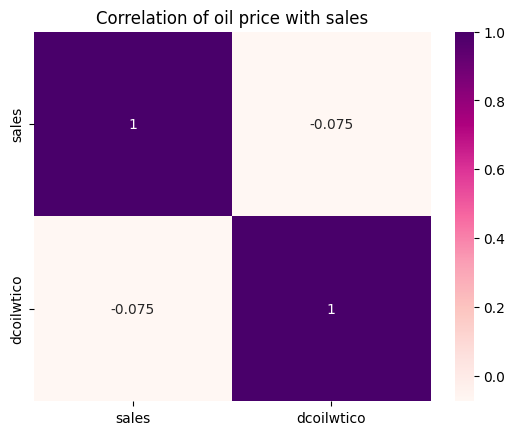

In [57]:
sns.heatmap(with_oil[['sales','dcoilwtico']].corr(), annot=True, cmap ='RdPu')
plt.title('Correlation of oil price with sales')
plt.show()

* There is no significant correlation between sales and oil price

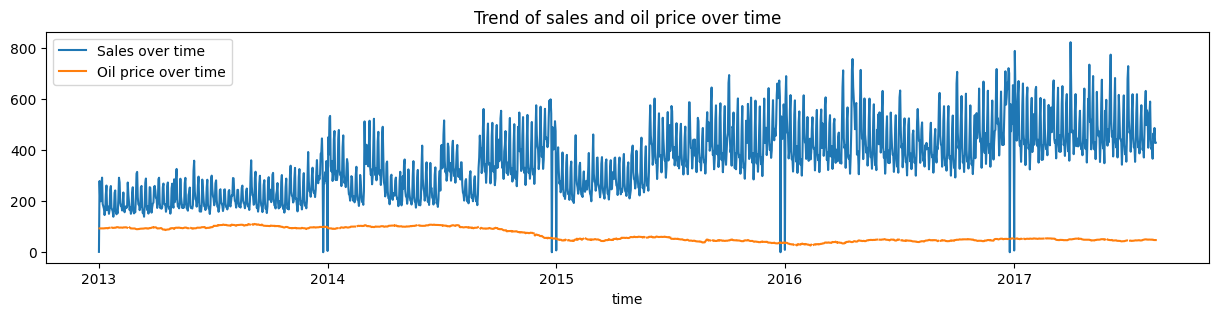

In [58]:
#plot sales and oil price
fig, ax = plt.subplots(figsize=(15,3))

ax.plot(with_oil.groupby('date').sales.sum().index, with_oil.groupby('date').sales.mean(), label='Sales over time')
ax.plot(with_oil.groupby('date').dcoilwtico.sum().index, with_oil.groupby('date').dcoilwtico.mean(), label='Oil price over time')

ax.set_xlabel('time')
ax.legend()

plt.title('Trend of sales and oil price over time')
plt.show()

In [59]:
with_oil = with_oil.set_index('date')

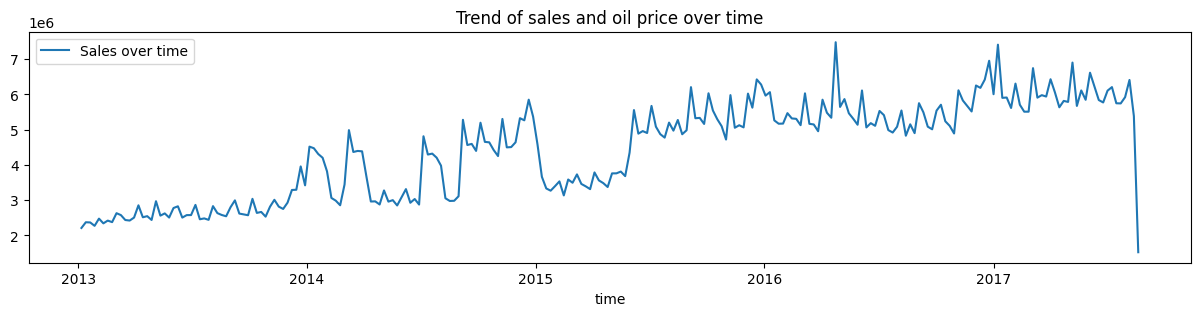

In [60]:
#plot sales and oil price
fig, ax = plt.subplots(figsize=(15,3))

ax.plot(with_oil.sales.resample('W').sum(), label='Sales over time')
ax.plot(with_oil.dcoilwrico.resample('W').sum(), label='Oil over time')

ax.set_xlabel('time')
ax.legend()

plt.title('Trend of sales and oil price over time')
plt.show()

Did the Earthquake on 16-04-2016 affect sales?

In [61]:
#checking average sales 14 days before and after 16/04/2016
before_eq = train[['store_nbr','family','sales']][(train.index > '2016-04-01') & (train.index < '2016-04-17')] #sales 14 days before 16th inclusive.

after_eq = train[['store_nbr','family','sales']][(train.index > '2016-04-15') & (train.index < '2016-05-01')] #sales 14 days after 16th inclusive

print(f"The average sales 14 days before the earthquake was {(before_eq['sales'].mean()):,.2f}$ and 14 days after was {(after_eq['sales'].mean()):,.2f}$")
print(f"This represents an average change of {(after_eq['sales'].mean() - before_eq['sales'].mean()):,.2f}$")

The average sales 14 days before the earthquake was 447.59$ and 14 days after was 523.33$
This represents an average change of 75.73$


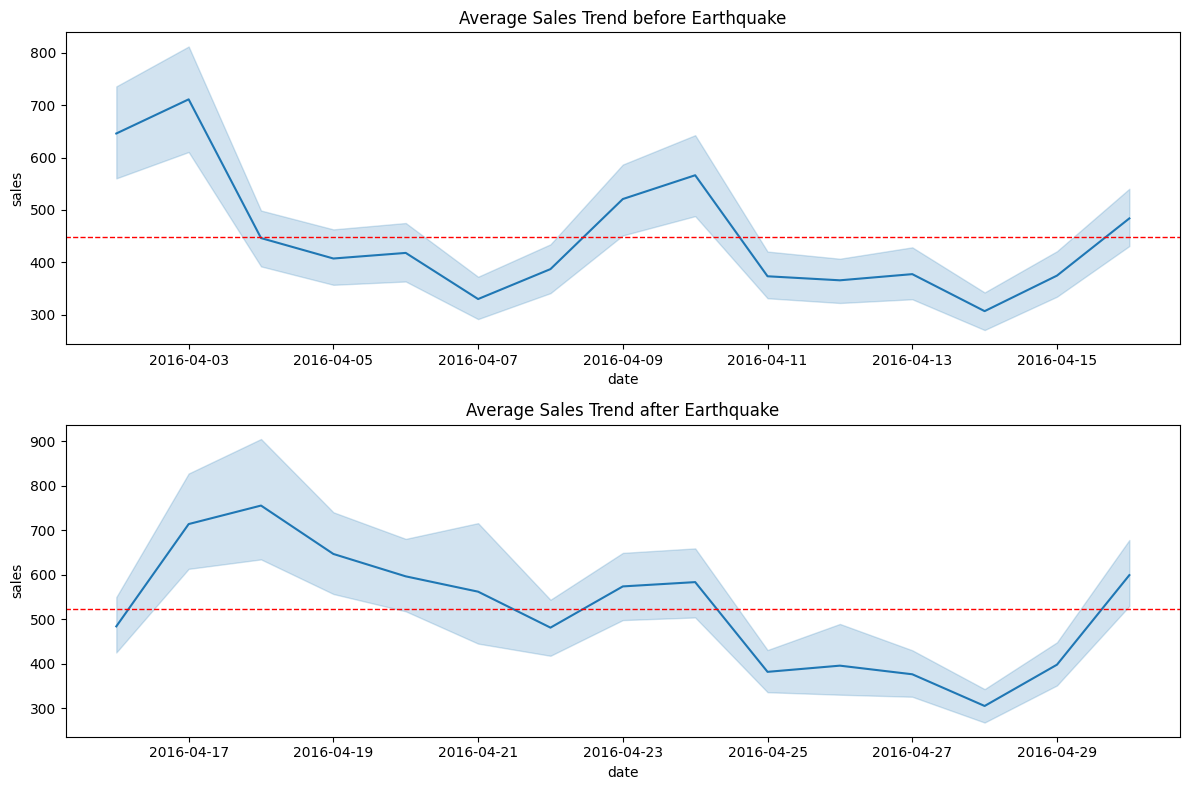

In [62]:
fig, axs = plt.subplots(2, 1, figsize=(12,8))

sns.lineplot(before_eq['sales'], ax=axs[0])
axs[0].axhline(y=before_eq['sales'].mean(), xmin=-1, xmax=1, color='r', linestyle='--', lw=1)
sns.lineplot(after_eq['sales'], ax=axs[1])
axs[1].axhline(y=after_eq['sales'].mean(), xmin=-1, xmax=1, color='r', linestyle='--', lw=1)

axs[0].set_title('Average Sales Trend before Earthquake')
axs[1].set_title('Average Sales Trend after Earthquake')

plt.tight_layout()
plt.show()

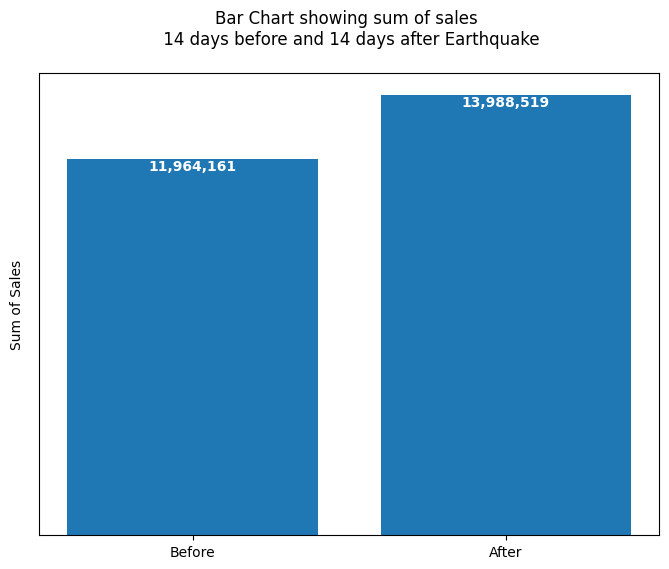

In [63]:
#Sum sales before and after Earthquake
check_eq=[(before_eq['sales'].sum()),(after_eq['sales'].sum())]

#plot balance of sales
plt.figure(figsize=(8,6))
plt.bar(x=['Before','After'], height=check_eq)

#annotate bars
for i, v in enumerate(check_eq):
    plt.text(i, v, f"{v:,.0f}", ha="center", va='top', fontweight='bold', color='white')

plt.title(f'Bar Chart showing sum of sales \n 14 days before and 14 days after Earthquake\n')
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.tick_params(left=False)
plt.ylabel('Sum of Sales')
plt.show()

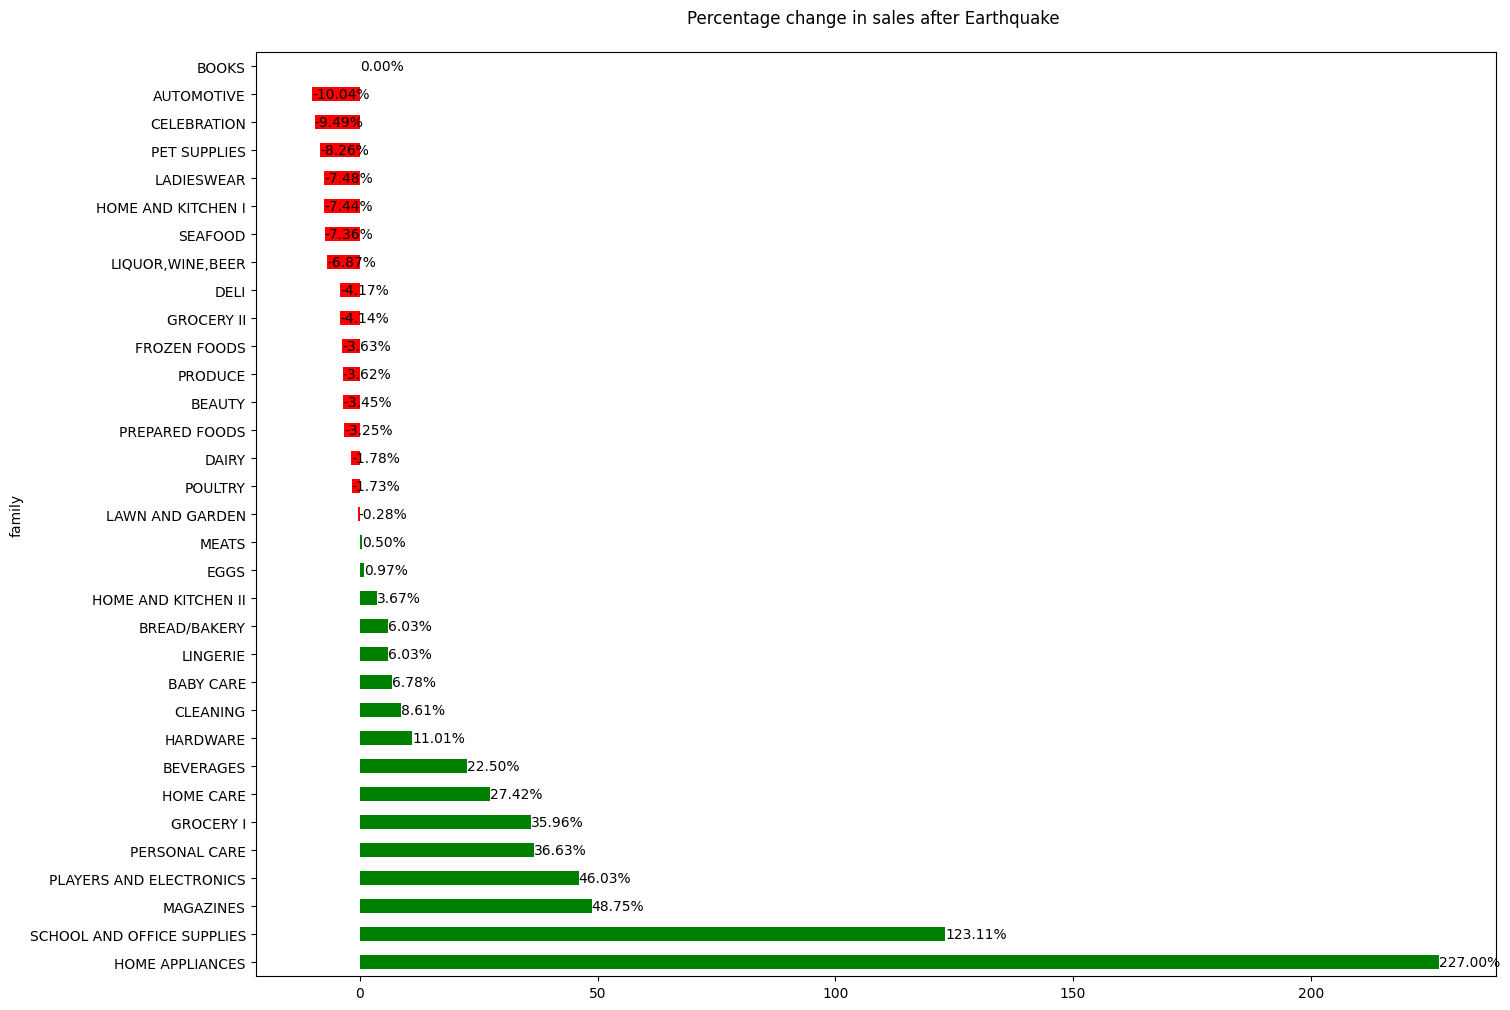

In [64]:
#create dataframe for sales before and after 31st 
family_trend_eq = pd.DataFrame({'before':(before_eq.groupby('family').sales.sum()),'after':(after_eq.groupby('family').sales.sum())})

#create column for the change in demand before and after 31st payday in percentage
for item in enumerate(family_trend_eq.index):
    family_trend_eq['pct_change'] = (((family_trend_eq['after'] - family_trend_eq['before'])/family_trend_eq['before'])*100)

#select the pct_change and sorting in descending order
eq_changes = family_trend_eq.sort_values('pct_change', ascending=False)['pct_change'] 

#plot the pct_changes in sales
clrs = ['green' if (x > 0) else 'red' for x in eq_changes ]

plt.figure(figsize = (16,12))

ax = eq_changes.plot.barh(color=clrs)

for p in ax.patches: #annotate the bars
    width = p.get_width()
    ax.text(width, p.get_y() + p.get_height() / 2, 
            f"{width:.2f}%", ha="left", va="center")

plt.title(f'Percentage change in sales after Earthquake \n')

plt.show()

## **3. Data Preparation**

In [65]:
#sort index
train = train.sort_index()
train

store_nbr                   family  sales  onpromotion DayOfWeek  \
date                                                                           
2013-01-01          1               AUTOMOTIVE   0.00            0   Tuesday   
2013-01-01         42              CELEBRATION   0.00            0   Tuesday   
2013-01-01         42             BREAD/BAKERY   0.00            0   Tuesday   
2013-01-01         42                    BOOKS   0.00            0   Tuesday   
2013-01-01         42                BEVERAGES   0.00            0   Tuesday   
...               ...                      ...    ...          ...       ...   
2017-08-15         25                  POULTRY 172.52            0   Tuesday   
2017-08-15         25  PLAYERS AND ELECTRONICS   3.00            0   Tuesday   
2017-08-15         25             PET SUPPLIES   3.00            0   Tuesday   
2017-08-15         26                    BOOKS   0.00            0   Tuesday   
2017-08-15          1                BABY CARE   0.00            0   Tuesday   

            Month  Quarter  Year  dates  
date                                     
2013-01-01      1        1  2013      1  
2013-01-01      1        1  2013      1  
2013-01-01      1        1  2013      1  
2013-01-01      1        1  2013      1  
2013-01-01      1        1  2013      1  
...           ...      ...   ...    ...  
2017-08-15      8        3  2017     15  
2017-08-15      8        3  2017     15  
2017-08-15      8        3  2017     15  
2017-08-15      8        3  2017     15  
2017-08-15      8        3  2017     15  

[3008016 rows x 9 columns]

In [66]:
#split to train and test data
train_data = train.loc[:'2017-01-01']
test_data = train.loc['2017-01-01':]

In [67]:
#using sarima for modelling as a baseline
# resample the data to monthly frequency
data_monthly = train_data.sales.resample('ME').sum()

# fit a SARIMA model using auto_arima to get optimal pdq values
model = pm.auto_arima(data_monthly, 
                      seasonal=True, m=12, d=1, D=1, #specify seasonality, period and seasonal differencing values
                      start_p=0, max_p=5,start_q=0, max_q=5, start_P=0, max_P=5, start_Q=0, max_Q=5, #specify ranges to be searched
                      information_criterion='aic', trace=True, error_action='ignore', #select criterion, show trace process and ignore model selection errors
                      suppress_warnings=True, stepwise=True, 
                      random_state=42) #Set stepwise to true for gridsearch and random state

# print the best SARIMA model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1234.211, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1226.332, Time=0.81 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1228.931, Time=1.34 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1230.384, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1228.262, Time=5.69 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1228.301, Time=1.50 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1228.571, Time=2.39 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=1229.815, Time=9.61 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1229.498, Time=0.84 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1228.422, Time=1.06 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1228.635, Time=1.77 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1227.159, Time=1.22 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1230.160, Time=3.55 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=1227.081, Time=1.14 sec

Best model:  ARIMA

In [68]:
model

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [69]:
# fit SARIMA model using SARIMAX
sarima_month = SARIMAX(train_data['sales'].resample('ME').sum(), order=(1,1,0), seasonal_order=(1,1,0,12))
sarima_fit = sarima_month.fit()

# generate predictions
test_data_month = test_data.resample('ME').sum()

# predict for the days in test_data
prediction = sarima_fit.predict(start=test_data_month.index.min(), end=test_data_month.index.max(), dynamic=True)
prediction

2017-01-31   22,246,919.46
2017-02-28   20,941,302.33
2017-03-31   22,434,135.56
2017-04-30   23,231,013.58
2017-05-31   24,394,424.81
2017-06-30   25,693,112.80
2017-07-31   26,548,120.93
2017-08-31   26,594,754.73
Freq: ME, Name: predicted_mean, dtype: float64

In [70]:
test_data_month['sales']

date
2017-01-31   26,328,159.94
2017-02-28   23,250,112.37
2017-03-31   26,704,017.69
2017-04-30   25,895,308.49
2017-05-31   26,911,847.25
2017-06-30   25,682,822.12
2017-07-31   27,011,477.57
2017-08-31   12,433,322.94
Freq: ME, Name: sales, dtype: float64

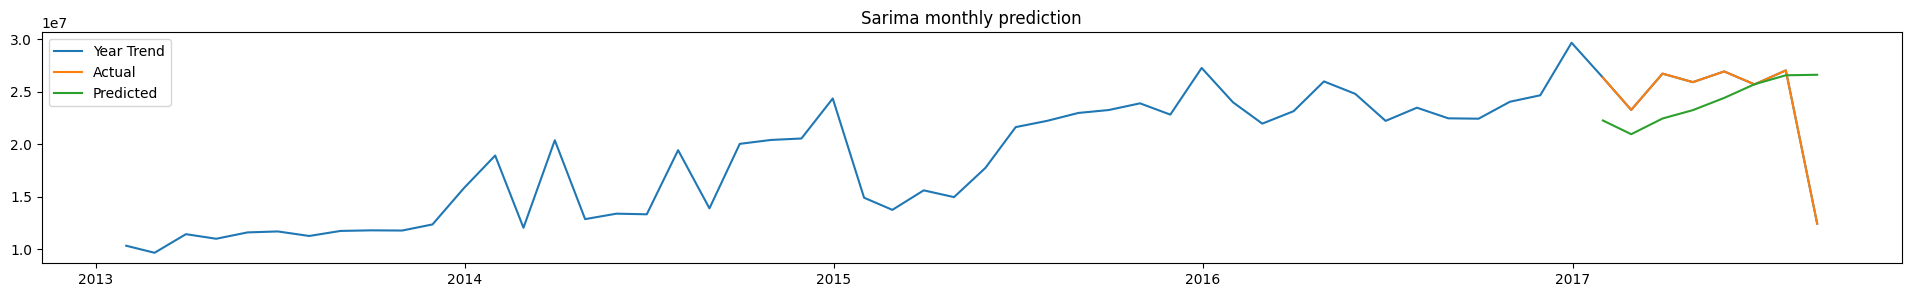

In [71]:
# Plot the annual trend, actual values and the predicted values
plt.figure(figsize=(24,3))
plt.plot(train['sales'].resample('ME').sum(), label='Year Trend')
plt.plot(test_data_month['sales'], label='Actual')
plt.plot(prediction, label='Predicted')
plt.legend()
plt.title('Sarima monthly prediction')
plt.show()

In [70]:
#evaluate model performance
# calculate the MSE
mse = mean_squared_error(test_data_month['sales'].resample('ME').sum(), prediction)

# calculate the MAE
mae = mean_absolute_error(test_data_month['sales'].resample('ME').sum(), prediction)

# calculate the RMSE
rmse = sqrt(mean_squared_error(test_data_month['sales'].resample('ME').sum(), prediction))

# calculate the RMSLE
rmsle = sqrt(mean_squared_error(np.log1p(test_data_month['sales'].resample('ME').sum()), np.log1p(prediction)))


print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'RMSLE: {rmsle:2f}')

MSE: 31801982448894.61
MAE: 3809591.14
RMSE: 5639324.64
RMSLE: 0.289289


In [ ]:
#using sarima for modelling as a baseline
# resample the data to weekly frequency
data_weekly = train_data.sales.resample('W').sum()

# fit a SARIMA model using auto_arima to get optimal pdq values
#model = pm.auto_arima(data_weekly, 
#                      seasonal=True, m=52, d=1, D=1, #specify seasonality, period and seasonal differencing values
#                      start_p=0, max_p=2,start_q=0, max_q=2, start_P=0, max_P=2, start_Q=0, max_Q=2, #specify ranges to be searched
#                      information_criterion='aic', trace=True, error_action='ignore', #select criterion, show trace process and ignore model selection errors
#                      suppress_warnings=True, stepwise=True, random_state=42) #Set stepwise to true for gridsearch and random state

# print the best SARIMA model
#print(model.summary())

In [ ]:
# fit SARIMA model using SARIMAX
sarima_wk = SARIMAX(train_data['sales'].resample('W').sum(), order=(1,1,2), seasonal_order=(0,1,1,52))
sarima_wk = sarima_wk.fit()

# generate predictions
test_data_wk = test_data.resample('W').sum()

# predict for the days in test_data
wk_prediction = sarima_wk.predict(start=test_data_wk.index.min(), end=test_data_wk.index.max(), dynamic=True)
wk_prediction

2017-01-01   6,792,368.26
2017-01-08   6,612,652.21
2017-01-15   6,114,406.57
2017-01-22   6,028,918.57
2017-01-29   6,025,904.09
2017-02-05   6,092,771.06
2017-02-12   5,913,342.45
2017-02-19   6,000,191.10
2017-02-26   5,985,532.56
2017-03-05   6,686,383.14
2017-03-12   6,102,799.15
2017-03-19   6,079,039.81
2017-03-26   5,969,560.71
2017-04-02   6,454,872.19
2017-04-09   6,098,414.55
2017-04-16   6,012,134.72
2017-04-23   7,009,291.61
2017-04-30   6,303,786.12
2017-05-07   6,339,471.30
2017-05-14   6,166,483.93
2017-05-21   6,028,897.24
2017-05-28   6,164,863.72
2017-06-04   6,977,992.17
2017-06-11   6,222,317.53
2017-06-18   6,319,174.90
2017-06-25   6,247,548.02
2017-07-02   6,926,936.87
2017-07-09   6,621,030.00
2017-07-16   6,365,527.49
2017-07-23   6,288,465.26
2017-07-30   6,474,984.13
2017-08-06   6,504,612.15
2017-08-13   6,217,790.43
2017-08-20   6,271,500.30
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [ ]:
test_data_wk['sales']

date
2017-01-01      12,082.50
2017-01-08   7,410,348.16
2017-01-15   5,902,413.60
2017-01-22   5,911,570.75
2017-01-29   5,615,398.87
2017-02-05   6,306,449.49
2017-02-12   5,706,049.27
2017-02-19   5,509,823.91
2017-02-26   5,509,811.98
2017-03-05   6,744,430.48
2017-03-12   5,907,994.39
2017-03-19   5,978,472.45
2017-03-26   5,939,389.57
2017-04-02   6,429,788.60
2017-04-09   6,056,292.48
2017-04-16   5,634,508.94
2017-04-23   5,815,469.44
2017-04-30   5,787,303.61
2017-05-07   6,902,522.20
2017-05-14   5,672,860.23
2017-05-21   6,112,116.77
2017-05-28   5,847,001.48
2017-06-04   6,615,276.69
2017-06-11   6,230,842.90
2017-06-18   5,840,051.07
2017-06-25   5,771,429.78
2017-07-02   6,106,477.38
2017-07-09   6,207,049.14
2017-07-16   5,748,515.43
2017-07-23   5,744,335.16
2017-07-30   5,921,811.86
2017-08-06   6,410,193.61
2017-08-13   5,385,401.83
2017-08-20   1,523,584.34
Freq: W-SUN, Name: sales, dtype: float64

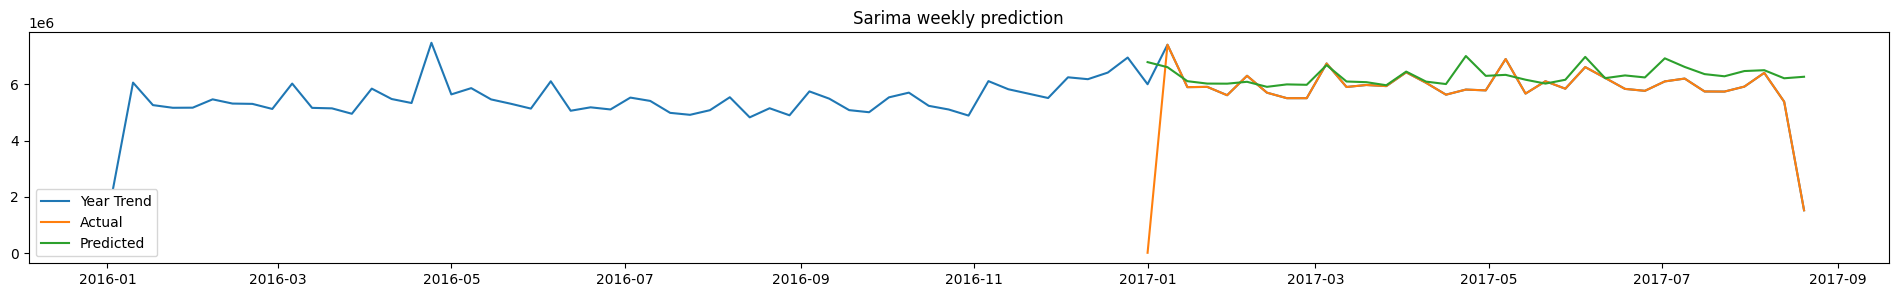

In [ ]:
# Plot the annual trend, actual values and the predicted values
plt.figure(figsize=(24,3))
plt.plot(train['2016-01-01':]['sales'].resample('W').sum(), label='Year Trend')
plt.plot(test_data_wk['sales'], label='Actual')
plt.plot(wk_prediction, label='Predicted')
plt.legend()
plt.title('Sarima weekly prediction')
plt.show()

In [ ]:
#evaluate model performance
# calculate the MSE
mse = mean_squared_error(test_data_wk['sales'].resample('W').sum(), wk_prediction)

# calculate the MAE
mae = mean_absolute_error(test_data_wk['sales'].resample('W').sum(), wk_prediction)

# calculate the RMSE
rmse = sqrt(mean_squared_error(test_data_wk['sales'].resample('W').sum(), wk_prediction))

# calculate the RMSLE
rmsle = sqrt(mean_squared_error(np.log1p(test_data_wk['sales'].resample('W').sum()), np.log1p(wk_prediction)))


print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'RMSLE: {rmsle:2f}')

MSE: 2223790410768.54
MAE: 695627.38
RMSE: 1491237.88
RMSLE: 1.115094


Sarima_Month predicts best on monthly sales with a respectable untuned RMSLE of `0.289` as compared to `1.11` for weekly sales, this could be because of the lack of support for more complex seasonality or a case for hyperparameter tuning in future iterations.

##### **Traditional Machine Learning Models**

Use XGBoost

To predict the sales of each family, we split the data for each family and extract only the sales in that product family

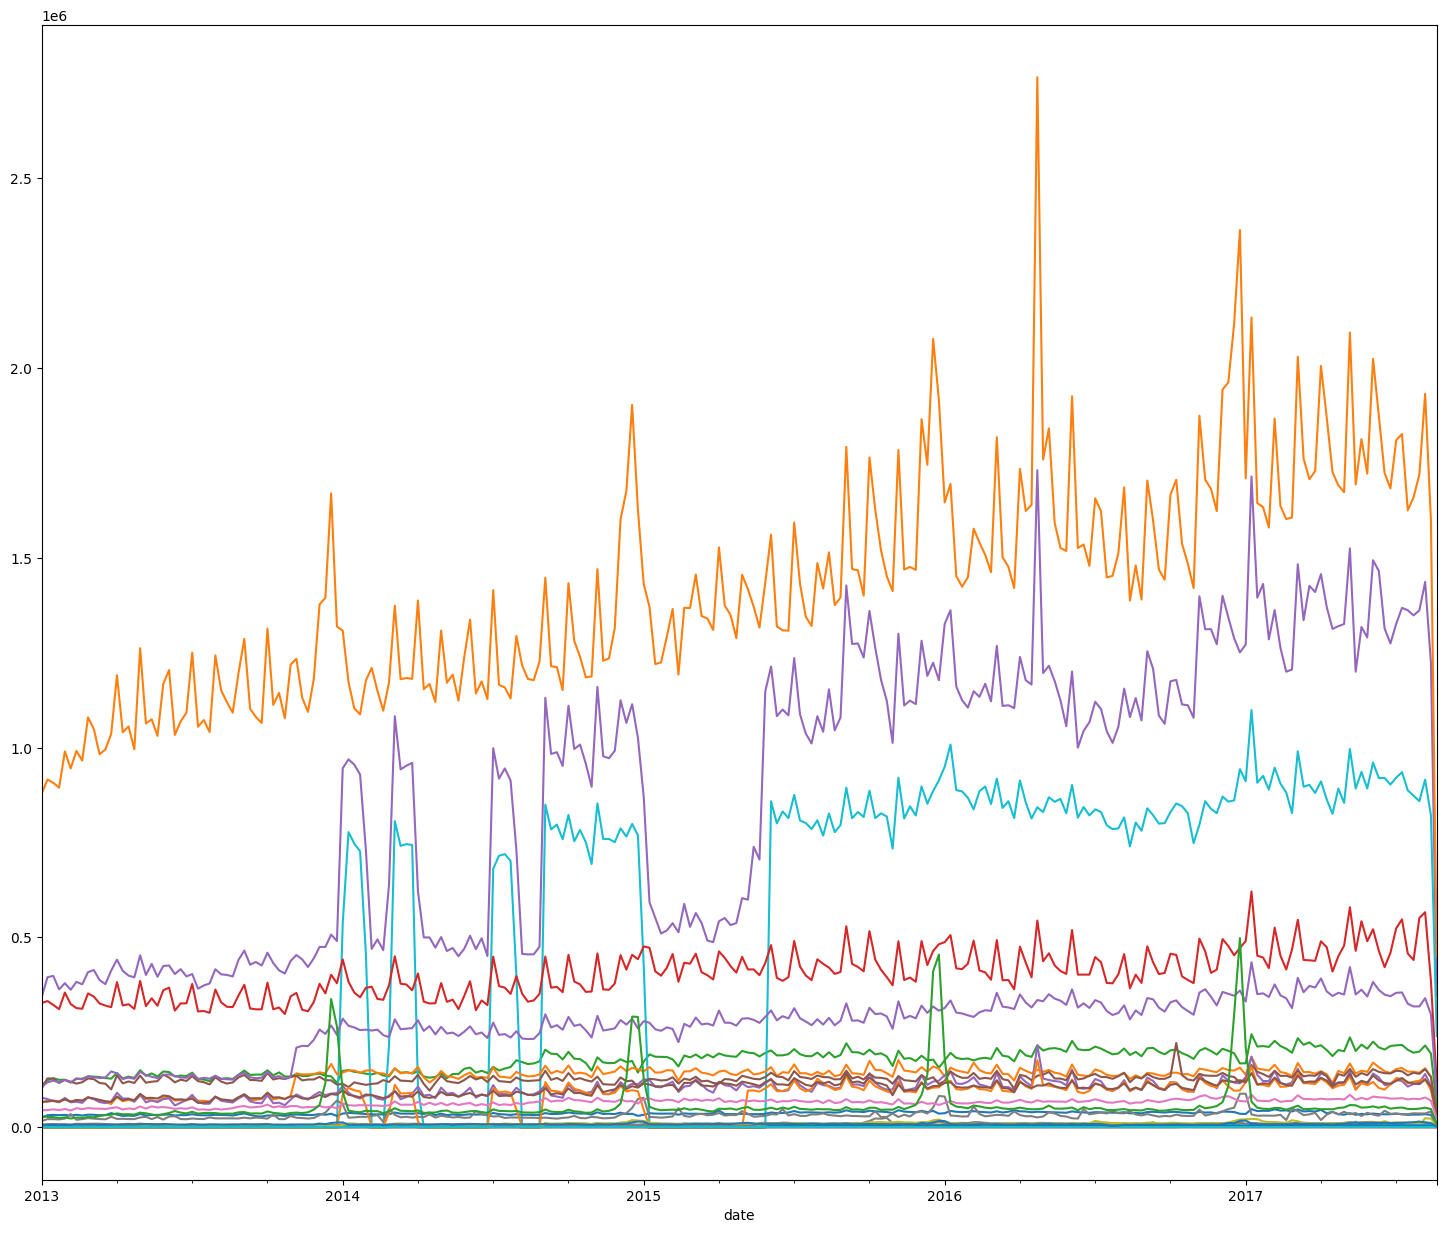

In [82]:
for category in train['family'].unique():
    train[train['family'] == category]['sales'].resample('W').sum().plot.line(figsize=(18,15), label=category) #plotting sales of each product family 

plt.show()

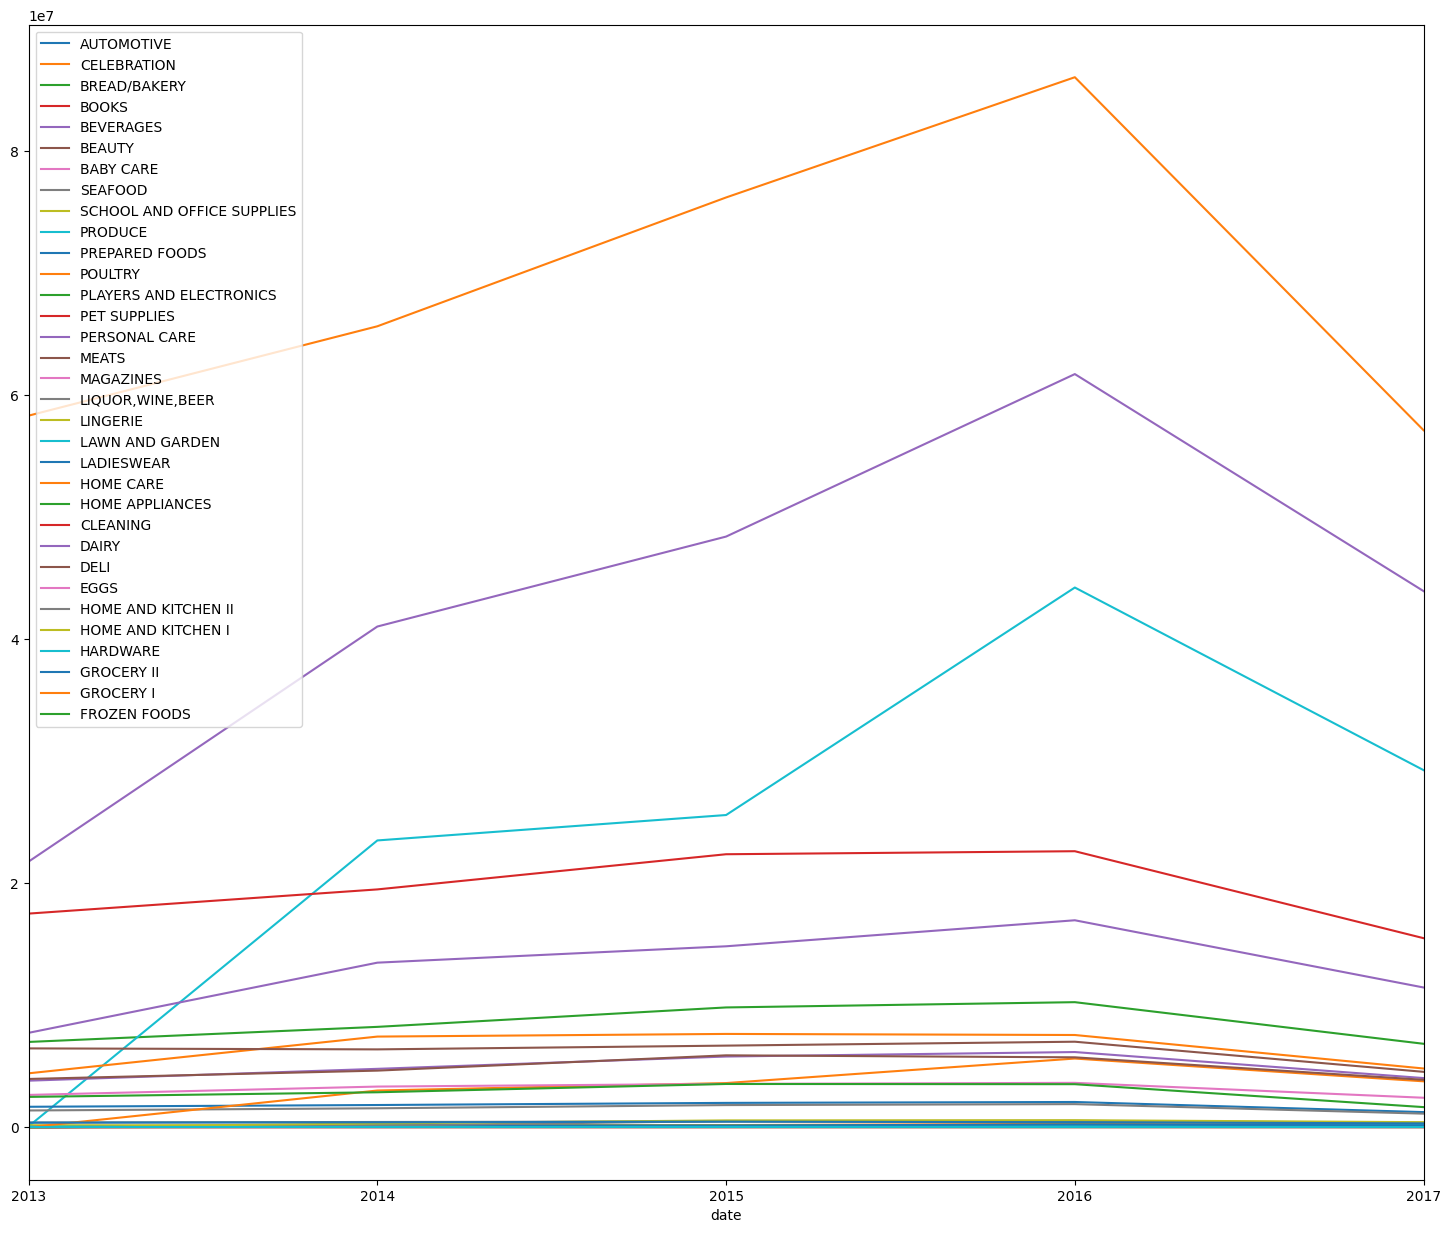

In [75]:
for category in train['family'].unique():
    train[train['family'] == category]['sales'].resample('Y').sum().plot.line(figsize=(18,15), label=category)
plt.legend(loc='best')
plt.show()

Different product families have differenct sales trends. and different contribution to the general store performance. 
Assuming all product lines 

In [63]:
#sales for each product split into a series. 
product_dfs = pd.DataFrame()

for product in train.family.unique():
    product_sales = train[train['family'] == product]
    product_dfs[product] = product_sales['sales']

product_dfs

AUTOMOTIVE  CELEBRATION  BREAD/BAKERY  BOOKS  BEVERAGES  BEAUTY  \
date                                                                          
2013-01-01        0.00         0.00          0.00   0.00       0.00    0.00   
2013-01-01        0.00         0.00          0.00   0.00       0.00    0.00   
2013-01-01        0.00         0.00          0.00   0.00       0.00    0.00   
2013-01-01        0.00         0.00          0.00   0.00       0.00    0.00   
2013-01-01        0.00         0.00          0.00   0.00       0.00    0.00   
...                ...          ...           ...    ...        ...     ...   
2017-08-15        1.00         1.00        122.00   0.00   1,253.00    3.00   
2017-08-15        5.00        16.00        637.12   0.00   2,877.00    3.00   
2017-08-15        6.00         4.00        685.00   0.00   3,660.00    5.00   
2017-08-15        7.00         5.00        385.94   0.00   1,636.00    3.00   
2017-08-15        3.00         4.00        215.00   0.00     762.00    0.00   

            BABY CARE  SEAFOOD  SCHOOL AND OFFICE SUPPLIES  PRODUCE  \
date                                                                  
2013-01-01       0.00     0.00                        0.00     0.00   
2013-01-01       0.00     0.00                        0.00     0.00   
2013-01-01       0.00     0.00                        0.00     0.00   
2013-01-01       0.00     0.00                        0.00     0.00   
2013-01-01       0.00     0.00                        0.00     0.00   
...               ...      ...                         ...      ...   
2017-08-15       1.00     1.00                        8.00   634.97   
2017-08-15       0.00     2.00                        0.00 3,651.33   
2017-08-15       0.00    19.21                        0.00   377.60   
2017-08-15       0.00    35.91                        0.00 2,258.66   
2017-08-15       0.00     4.00                        1.00 1,269.17   

            PREPARED FOODS  POULTRY  PLAYERS AND ELECTRONICS  PET SUPPLIES  \
date                                                                         
2013-01-01            0.00     0.00                     0.00          0.00   
2013-01-01            0.00     0.00                     0.00          0.00   
2013-01-01            0.00     0.00                     0.00          0.00   
2013-01-01            0.00     0.00                     0.00          0.00   
2013-01-01            0.00     0.00                     0.00          0.00   
...                    ...      ...                      ...           ...   
2017-08-15           31.00   131.07                     8.00          3.00   
2017-08-15          103.04   513.65                     4.00          0.00   
2017-08-15           18.00   118.62                     0.00          2.00   
2017-08-15           89.54   382.93                    12.00         14.00   
2017-08-15           25.47   172.52                     3.00          3.00   

            PERSONAL CARE  MEATS  MAGAZINES  LIQUOR,WINE,BEER  LINGERIE  \
date                                                                      
2013-01-01           0.00   0.00       0.00              0.00      0.00   
2013-01-01           0.00   0.00       0.00              0.00      0.00   
2013-01-01           0.00   0.00       0.00              0.00      0.00   
2013-01-01           0.00   0.00       0.00              0.00      0.00   
2013-01-01           0.00   0.00       0.00              0.00      0.00   
...                   ...    ...        ...               ...       ...   
2017-08-15         236.00 112.29       5.00             96.00      7.00   
2017-08-15         112.00 141.75       4.00             32.00      4.00   
2017-08-15         118.00 165.26       0.00              9.00      0.00   
2017-08-15         239.00 245.88       4.00             68.00      6.00   
2017-08-15          93.00 180.11      10.00             96.00      6.00   

            LAWN AND GARDEN  LADIESWEAR  HOME CARE  HOME APPLIANCES  

NameError: name 'product_dfs' is not defined

In [ ]:
train['week'] = train.index.isocalendar().week

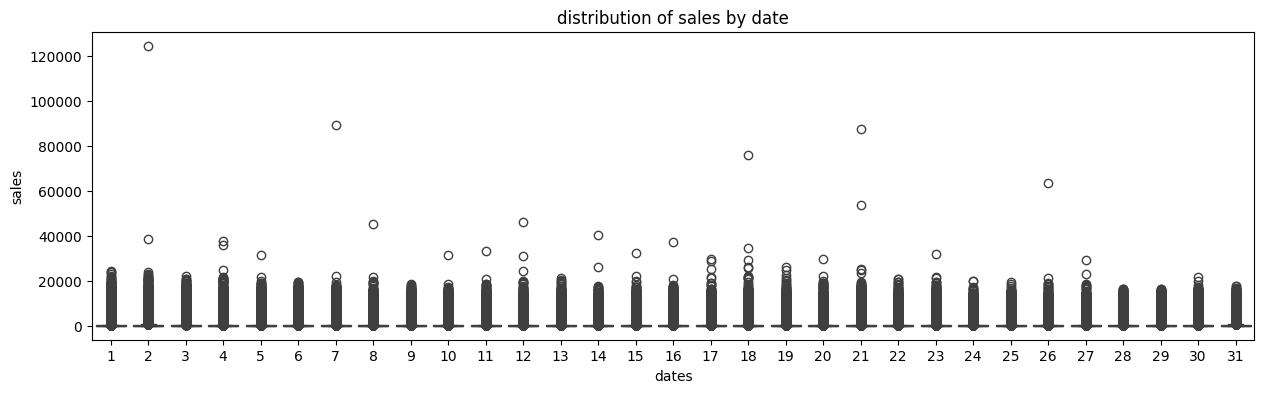

In [ ]:
plt.figure(figsize=(15,4))
sns.boxplot(data=train, y='sales', x='dates')
plt.title('distribution of sales by date')
plt.show()

In [ ]:
wks = train['sales'].resample('W').sum()
wks

date
2013-01-06   2,211,570.47
2013-01-13   2,373,617.84
2013-01-20   2,368,007.43
2013-01-27   2,272,164.67
2013-02-03   2,476,890.67
                 ...     
2017-07-23   5,744,335.16
2017-07-30   5,921,811.86
2017-08-06   6,410,193.61
2017-08-13   5,385,401.83
2017-08-20   1,523,584.34
Freq: W-SUN, Name: sales, Length: 242, dtype: float64

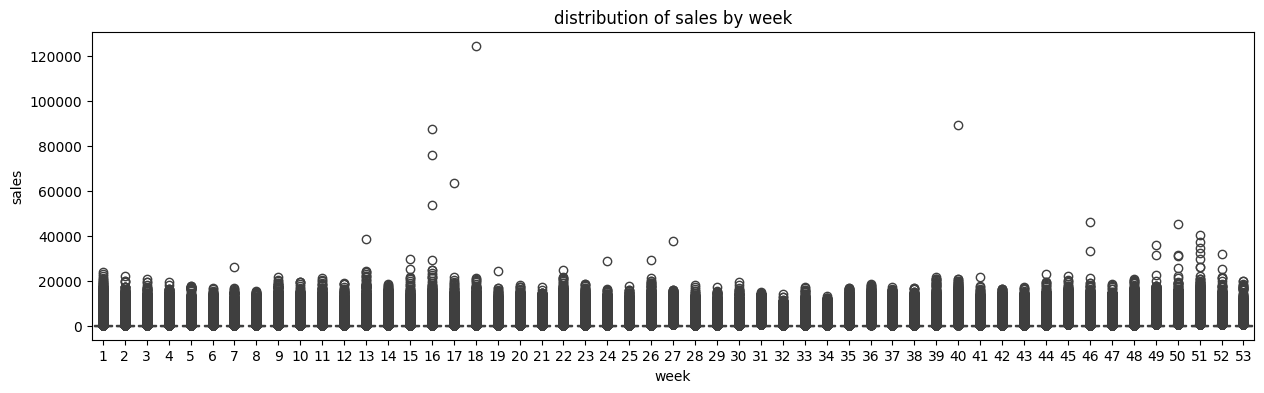

In [ ]:
plt.figure(figsize=(15,4))
sns.boxplot(data=train, y=train['sales'], x='week')
plt.title('distribution of sales by week')
plt.show()

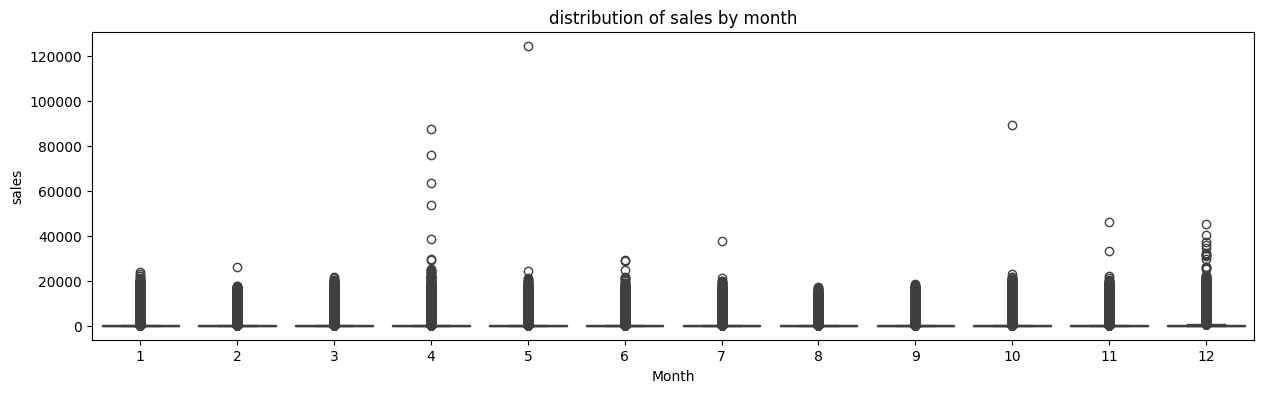

In [ ]:
plt.figure(figsize=(15,4))
sns.boxplot(data=train, y='sales', x='Month')
plt.title('distribution of sales by month')
plt.show()

## **5. Conclusion**